In [1]:
# Haplotype clustering and networking - this notebook sets up the utilties and generates figures for paper

In [2]:
%run hapclust_utils.ipynb
import matplotlib.patches as patches

## setup data

In [3]:
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5', mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))
hap_ids_995F = hap_ids[loc_995F]
hap_ids_995S = hap_ids[loc_995S]
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
hap_pops_995F = hap_pops[loc_995F]

# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])
hap_colors_995S = np.array([pop_colors[p] for p in hap_pops_995S])
hap_colors_995F = np.array([pop_colors[p] for p in hap_pops_995F])

## hierarchical clustering

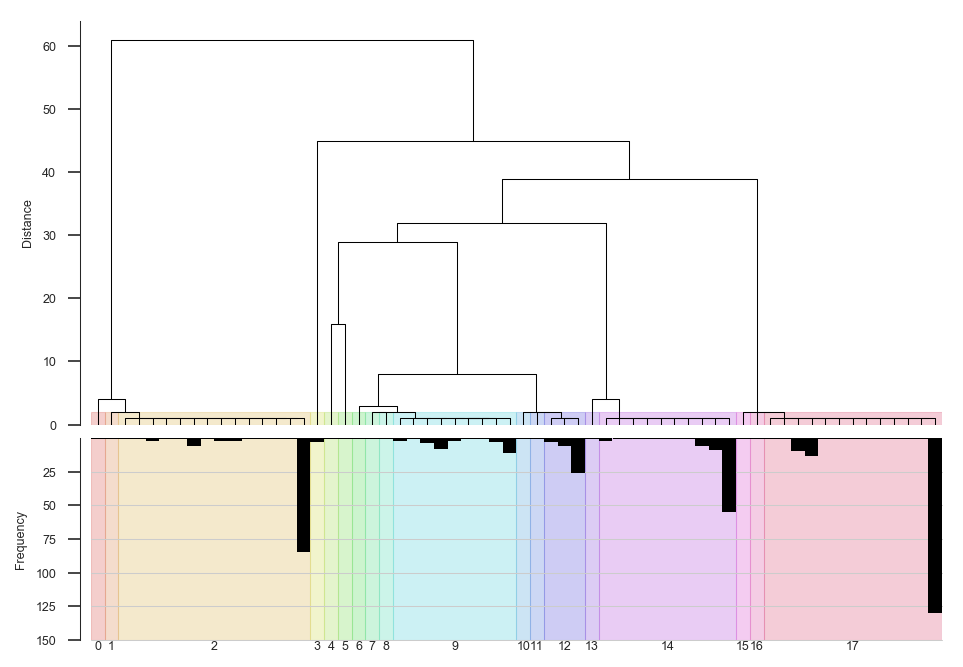

In [4]:
# Default plot... 
# cuts the tree at height 2 (so max distance within each cluster is 1)...
# highlights all clusters...
# labels all clusters.
fig_haplotypes_clustered(h_vgsc_995S, dpi=150);

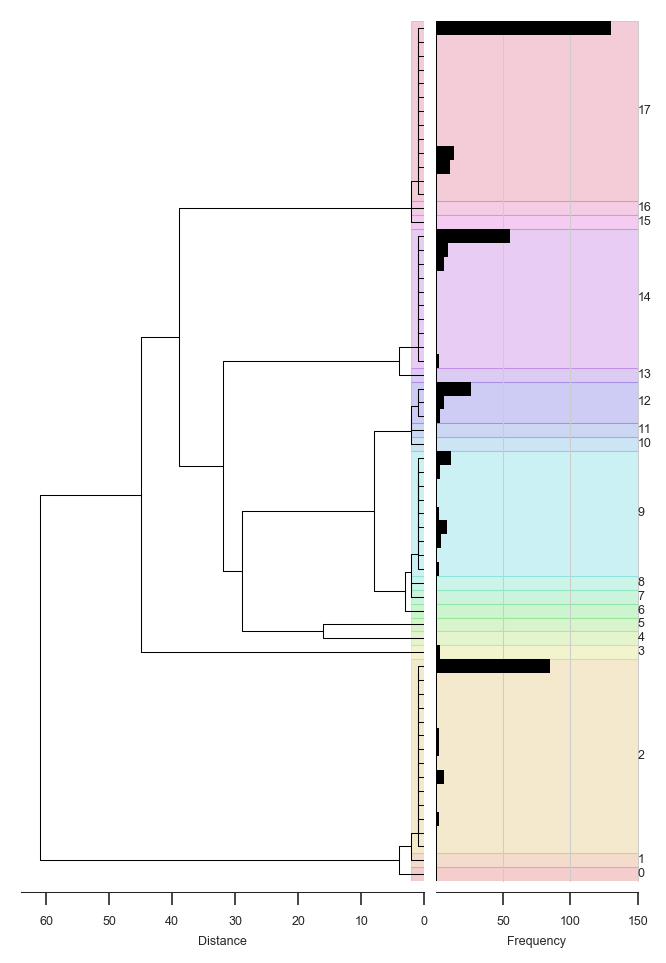

In [5]:
# Change the orientation...
fig_haplotypes_clustered(h_vgsc_995S, orientation='left', dpi=150);

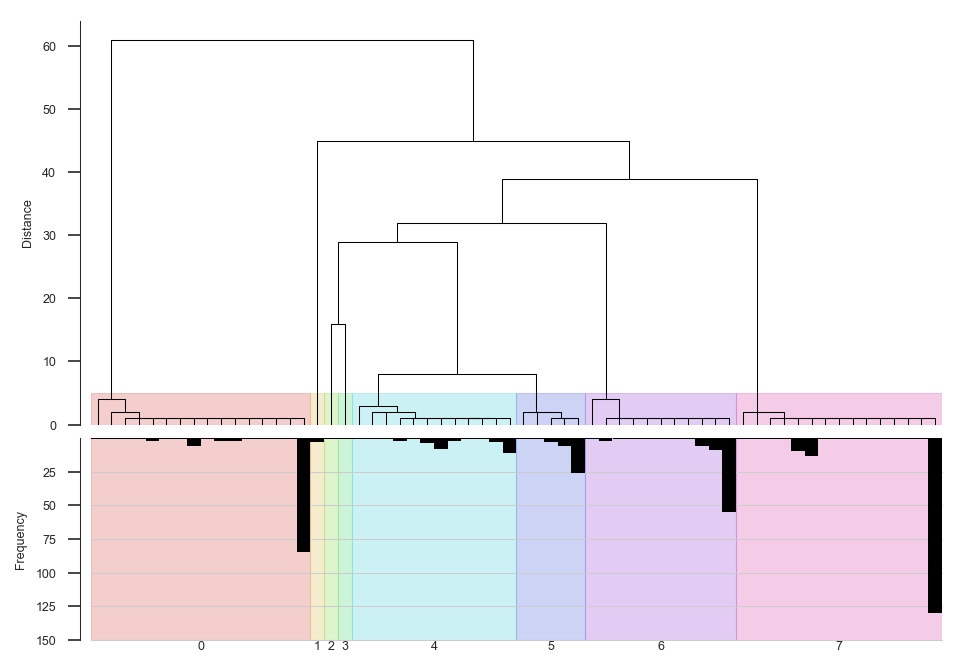

In [6]:
#try a different cut height
fig_haplotypes_clustered(h_vgsc_995S, cut_height=5, dpi=150);

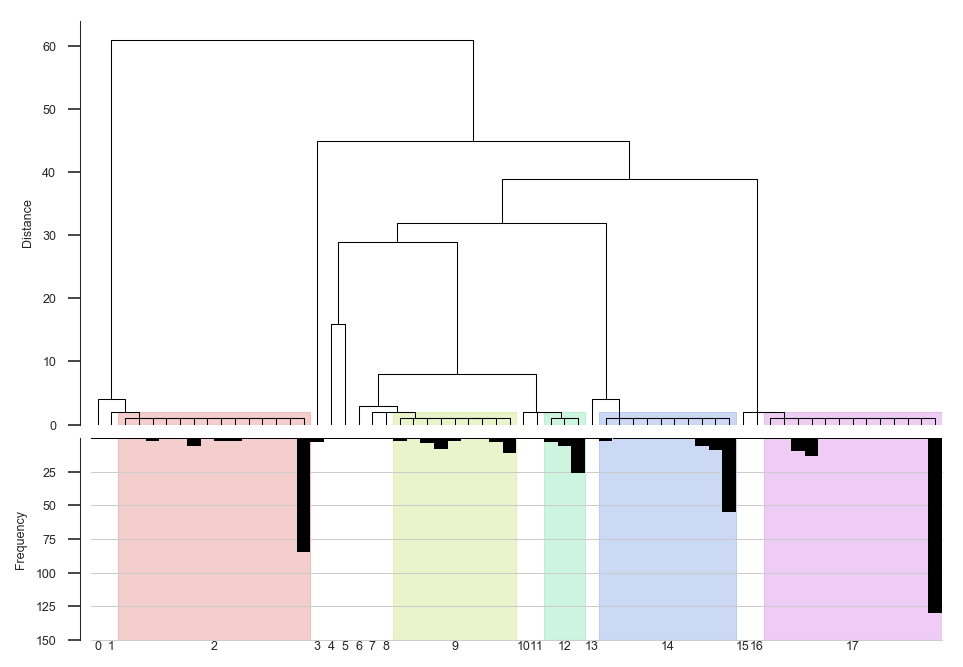

In [7]:
#choose to highlight clusters over a certain size
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5);

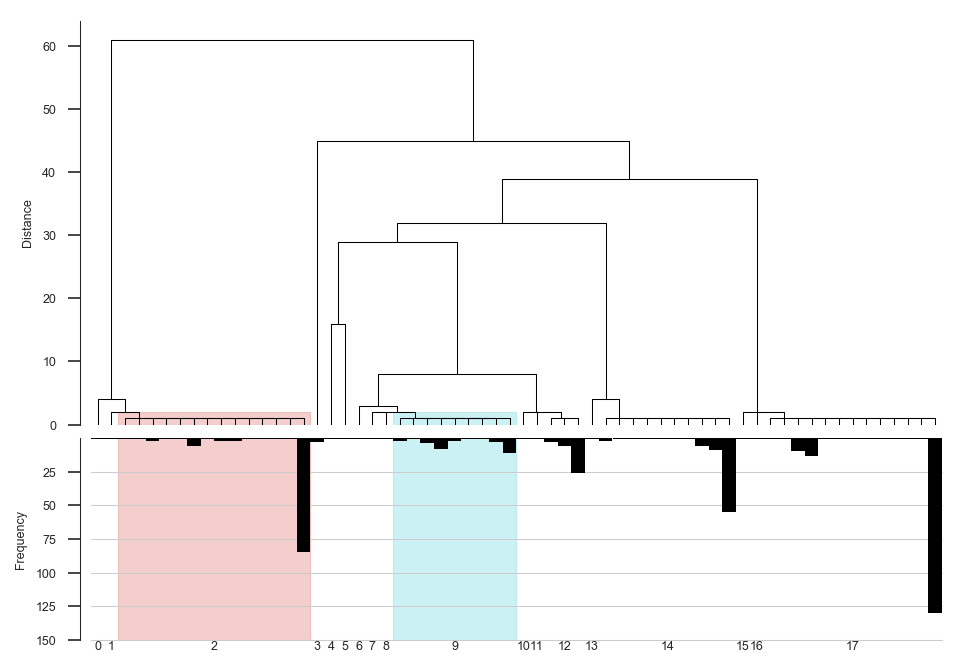

In [8]:
# Manually choose which clusters to highlight...
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=[2, 9]);

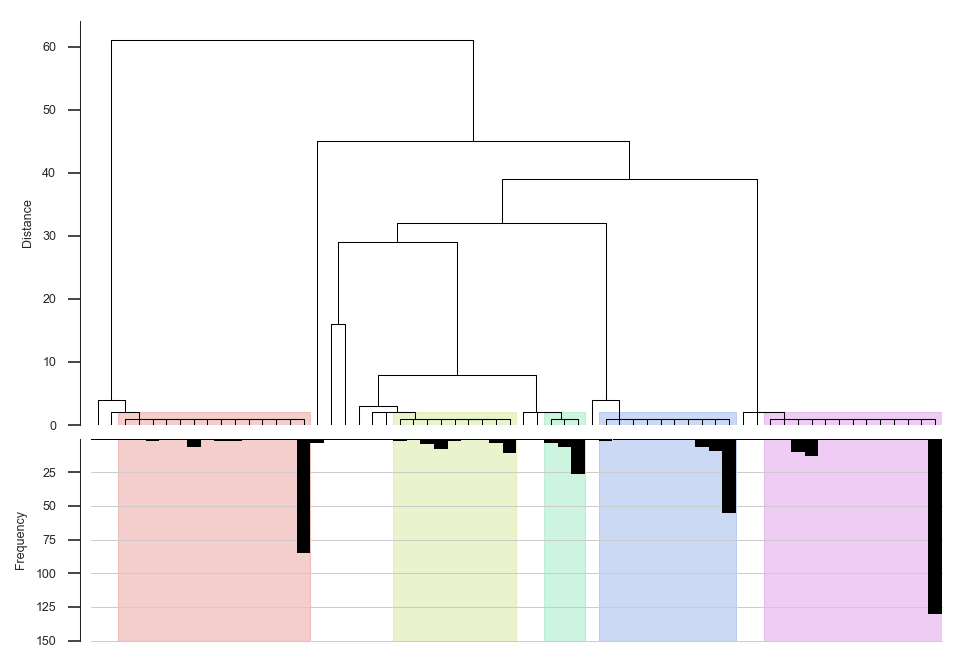

In [9]:
#turn of cluster labels
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5, label_clusters=False);

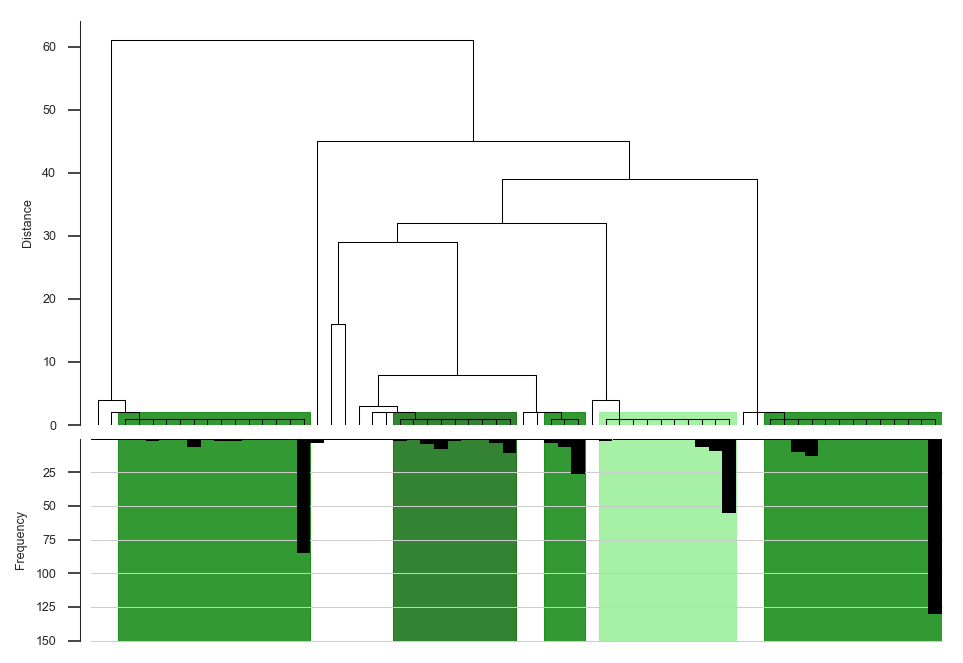

In [10]:
#use favourite colours
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5, label_clusters=False, highlight_colors=['green','darkgreen','green','lightgreen','green',], highlight_alpha=.8);

## return values

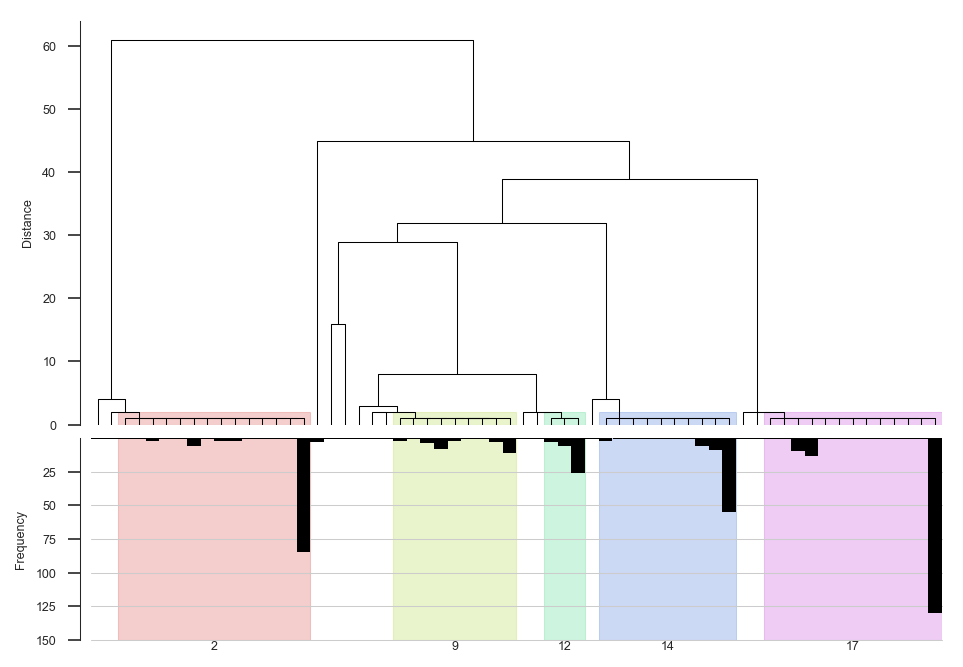

In [11]:
#checkout all these returns
fig, ax_dend, ax_freq, cluster_spans, leaf_obs = fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5, label_clusters=5);

### customising axes

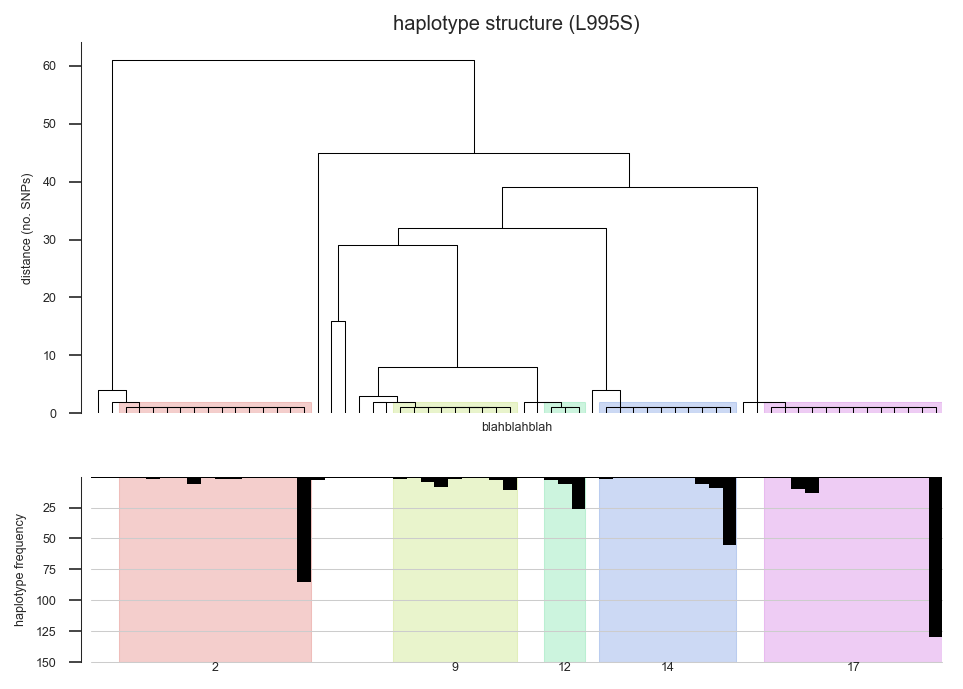

In [12]:
#e.g. use the returned axes objects (ax_dend, ax_freq) to customise labels etc....
fig, ax_dend, ax_freq, cluster_spans, leaf_obs = fig_haplotypes_clustered(h_vgsc_995S, dpi=150, label_clusters=5, highlight_clusters=5, subplot_pad=4)
ax_dend.set_title('haplotype structure (L995S)')
ax_dend.set_ylabel('distance (no. SNPs)')
ax_dend.set_xlabel('blahblahblah')
ax_freq.set_ylabel('haplotype frequency');

### accessing information about clusters

In [13]:
#cluster spans is useful for accessing info about each cluster
cluster_spans

[(0, 1, array([85])),
 (1, 2, array([17])),
 (2,
  16,
  array([  0,   1,   3,   4,   5,   7,  11,  15,  16,  19,  21,  23,  25,
          28,  29,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  45,
          47,  50,  51,  55,  57,  59,  61,  63,  64,  65,  71,  73,  75,
          77,  79,  82,  83,  86,  87,  88,  89,  91,  94,  95, 100, 101,
         103, 107, 109, 111, 114, 115, 119, 121, 122, 123, 126, 127, 128,
         129, 131, 133, 135, 137, 139, 140, 141, 144, 145, 147, 148, 149,
         151, 157, 158, 159, 163, 164, 165, 167, 169, 171, 172, 173, 176,
         177, 181, 183, 184, 185, 186, 187, 188, 189, 193, 195, 197, 199,
         201, 203])),
 (16, 17, array([277, 316, 346])),
 (17, 18, array([294])),
 (18, 19, array([369])),
 (19, 20, array([327])),
 (20, 21, array([278])),
 (21, 22, array([357])),
 (22,
  31,
  array([276, 282, 283, 284, 286, 287, 289, 291, 293, 299, 303, 304, 306,
         307, 311, 318, 320, 321, 322, 325, 326, 328, 330, 332, 336, 337,
         34

In [14]:
#e.g. cluster labelled 17 in plot
cluster_idx = 17
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]

In [15]:
dend_start, dend_stop

(49, 62)

In [16]:
#indices of haps in cluster
cluster_hap_indices

array([  2,   6,   8,   9,  10,  12,  13,  14,  18,  20,  22,  24,  26,
        27,  30,  31,  32,  34,  44,  46,  48,  49,  52,  53,  54,  56,
        58,  60,  62,  66,  67,  68,  69,  70,  72,  74,  76,  78,  80,
        81,  84,  90,  92,  93,  96,  97,  98,  99, 102, 104, 105, 106,
       108, 110, 112, 116, 117, 118, 120, 124, 125, 130, 132, 134, 136,
       138, 142, 143, 146, 150, 152, 153, 154, 155, 156, 160, 161, 162,
       166, 168, 170, 174, 175, 178, 179, 180, 182, 190, 191, 192, 194,
       196, 198, 200, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272])

In [17]:
len(cluster_hap_indices)

163

In [18]:
#these are relative to the haplotype array passed to function - not relative to the 1530 haplotypes!
#extract cluster 17 haplotypes
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_haps

<HaplotypeArray shape=(1718, 163) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

### outputting haplotype data in other formats

In [19]:
#names for haps
cluster_hap_ids = hap_ids_995S.take(cluster_hap_indices)
cluster_hap_ids.shape, cluster_hap_ids[0]

((163,), b'AC0091-Ca')

In [20]:
#dtype and transpose
sequences = cluster_haps.astype('S1').T
sequences.shape

(163, 1718)

In [21]:
#write out fasta format
cut_height = 2
fasta_fn = '../data/hapclust.995S.cut{}.cluster{}.fasta'.format(cut_height, cluster_idx)
allel.io.write_fasta(fasta_fn, sequences=list(sequences), names=cluster_hap_ids, mode='w', width=2000)

In [22]:
#make phylip format for TCS inputting
fasta_pasta = pyfasta.Fasta(fasta_fn)

phylip_fn = '../data/hapclust.995S.cut{}.cluster{}.phy'.format(cut_height, cluster_idx)
thefile = open(phylip_fn, 'w')
thefile.write(str(sequences.shape[0])+' '+str(sequences.shape[1])+'\n')
for i in fasta_pasta.keys():
    j = i.split('-')
    k = str(fasta_pasta[i]).replace('0', 'g').replace('1', 'c')
    thefile.write(j[0]+j[1]+'__'+k+'\n')

### output all the clusters as .phy to compare with AM's using TCS

In [23]:
def output_all_phy():
    
    fig, ax_dend, ax_freq, cluster_spans, leaf_obs = fig_haplotypes_clustered(h_vgsc_995S, dpi=150, label_clusters=5, highlight_clusters=5);
    for cluster_idx in 2, 9, 12, 14, 17:
        dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
        cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
        cluster_hap_ids = hap_ids_995S.take(cluster_hap_indices)
        sequences = cluster_haps.astype('S1').T

        fasta_fn = '../data/hapclust.995S.cut2.cluster{}.fasta'.format(cluster_idx)
        allel.io.write_fasta(fasta_fn, sequences=list(sequences), names=cluster_hap_ids, mode='w', width=2000)

        fasta_pasta = pyfasta.Fasta(fasta_fn)
        phylip_fn = '../data/hapclust.995S.cut2.cluster{}.phy'.format(cluster_idx)
        thefile = open(phylip_fn, 'w')
        thefile.write(str(sequences.shape[0])+' '+str(sequences.shape[1])+'\n')
        for i in fasta_pasta.keys():
            j = i.split('-')
            k = str(fasta_pasta[i]).replace('0', 'g').replace('1', 'c')
            thefile.write(j[0]+j[1]+'__'+k+'\n')

                
    fig, ax_dend, ax_freq, cluster_spans, leaf_obs = fig_haplotypes_clustered(h_vgsc_995F, dpi=150, label_clusters=5, cut_height=4, highlight_clusters=5);
    for cluster_idx in 4, 7, 8, 12, 16:
        dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
        cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
        cluster_hap_ids = hap_ids_995F.take(cluster_hap_indices)
        sequences = cluster_haps.astype('S1').T

        fasta_fn = '../data/hapclust.995F.cut4.cluster{}.fasta'.format(cluster_idx)
        allel.io.write_fasta(fasta_fn, sequences=list(sequences), names=cluster_hap_ids, mode='w', width=2000)

        fasta_pasta = pyfasta.Fasta(fasta_fn)
        phylip_fn = '../data/hapclust.995F.cut4.cluster{}.phy'.format(cluster_idx)
        thefile = open(phylip_fn, 'w')
        thefile.write(str(sequences.shape[0])+' '+str(sequences.shape[1])+'\n')
        for i in fasta_pasta.keys():
            j = i.split('-')
            k = str(fasta_pasta[i]).replace('0', 'g').replace('1', 'c')
            thefile.write(j[0]+j[1]+'__'+k+'\n')

            
        

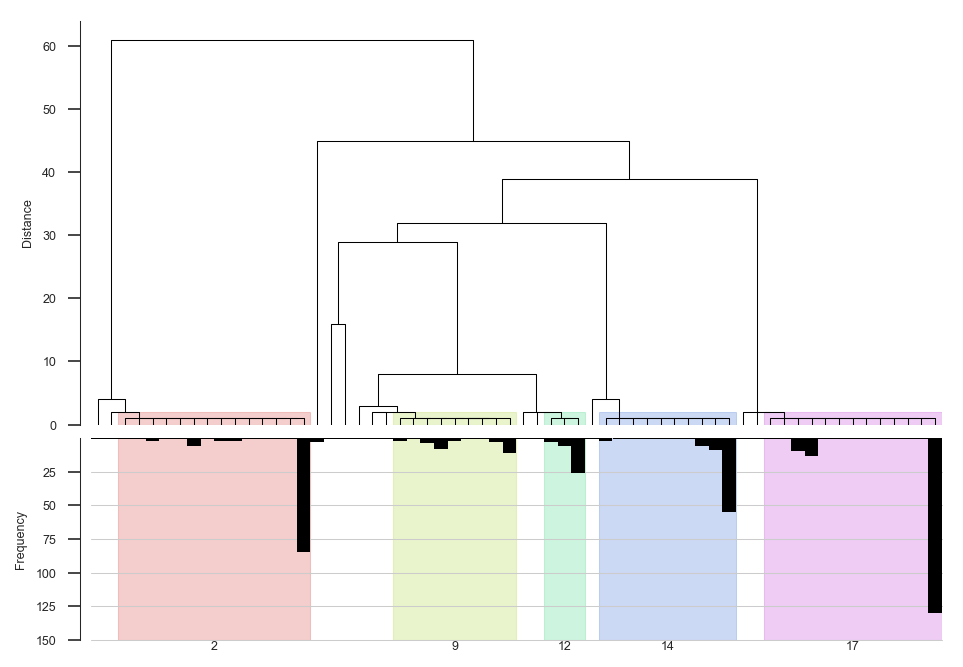

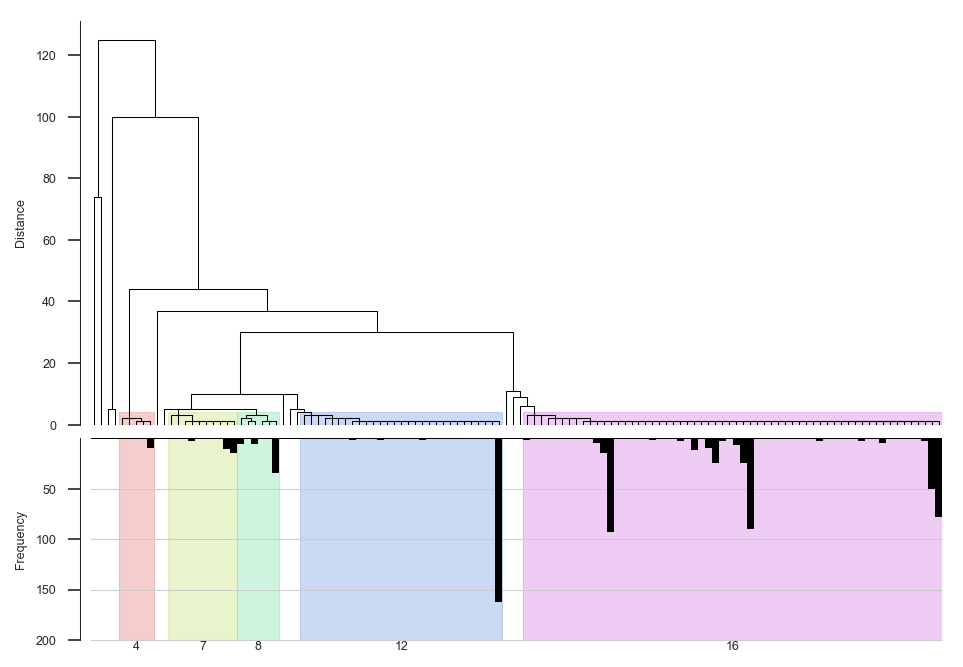

In [24]:
output_all_phy()

# Haplotype networks (minimum spanning tree)

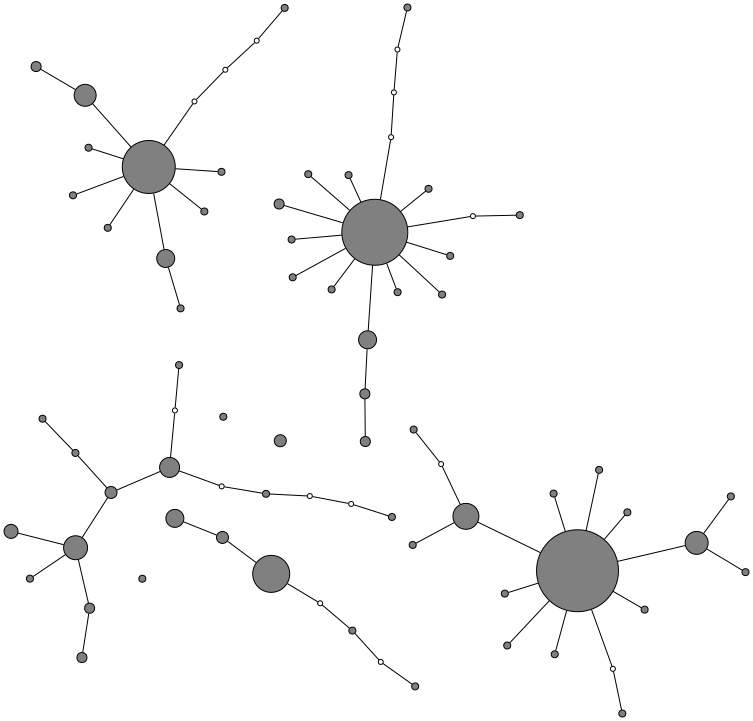

In [25]:
# make a network of all L995S haplotypes
#!! bug means that nodes get labelled unless you give show_node_labels a silly number
graph = graph_haplotype_network(h_vgsc_995S, show_node_labels=10000)
graph

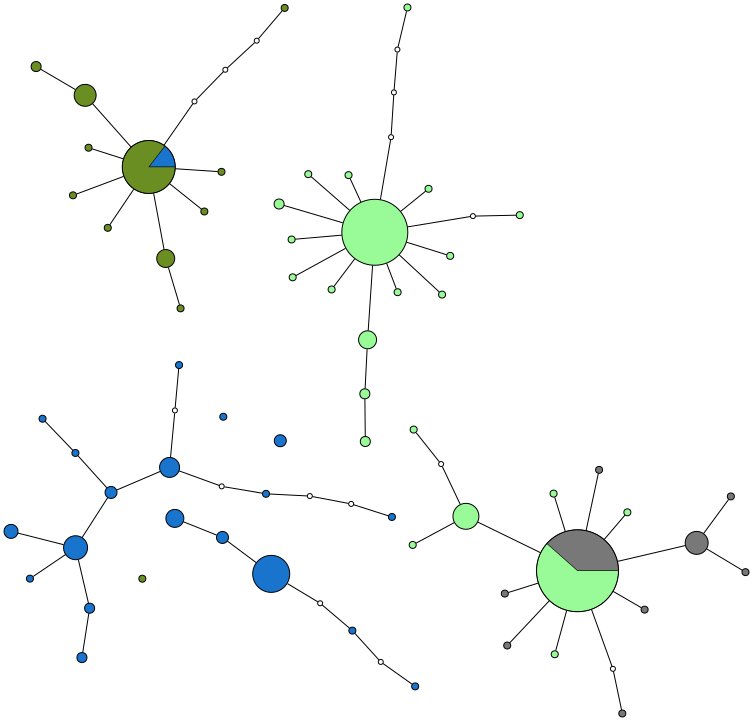

In [26]:
# add some color
graph = graph_haplotype_network(h_vgsc_995S, hap_colors=hap_colors_995S, show_node_labels=10000)
graph

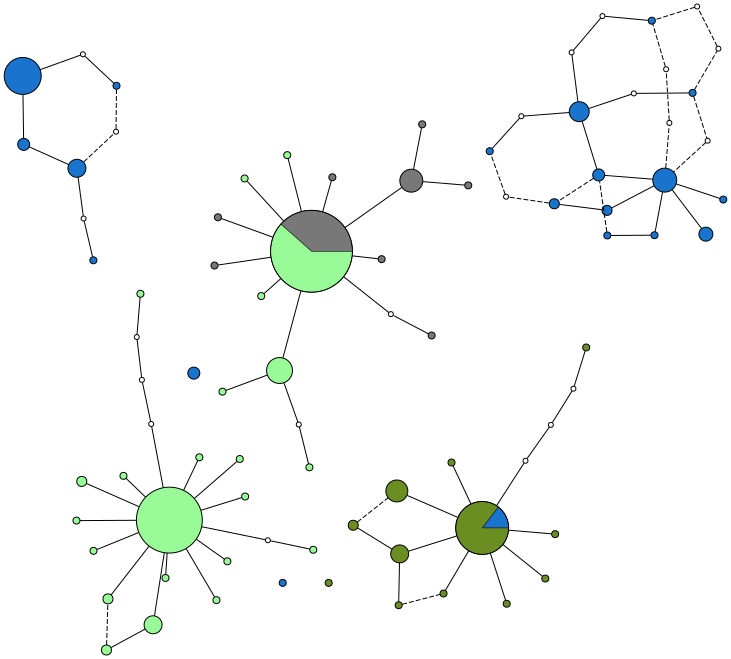

In [27]:
# try a different network building method - MAXIMUM SPANNING NETWORK
graph = graph_haplotype_network(h_vgsc_995S, hap_colors=hap_colors_995S, network_method='msn', show_node_labels=10000)
graph

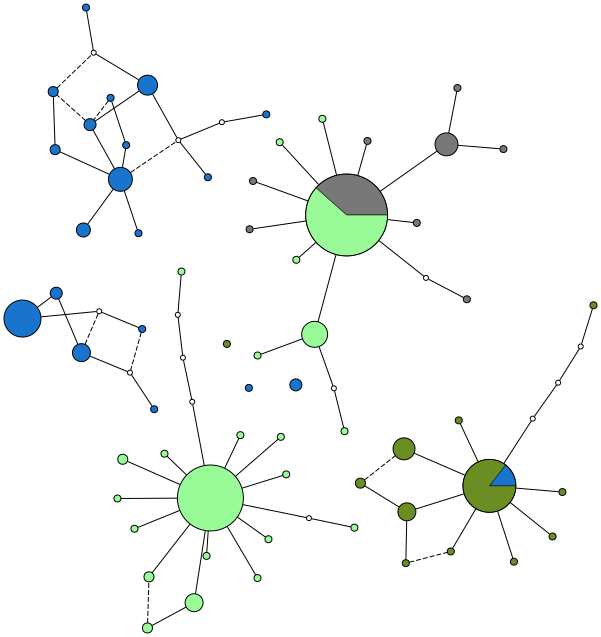

In [28]:
# try a different network building method - MEDIAN JOINING NETWORK
graph = graph_haplotype_network(h_vgsc_995S, hap_colors=hap_colors_995S, network_method='mjn', show_node_labels=10000)
graph

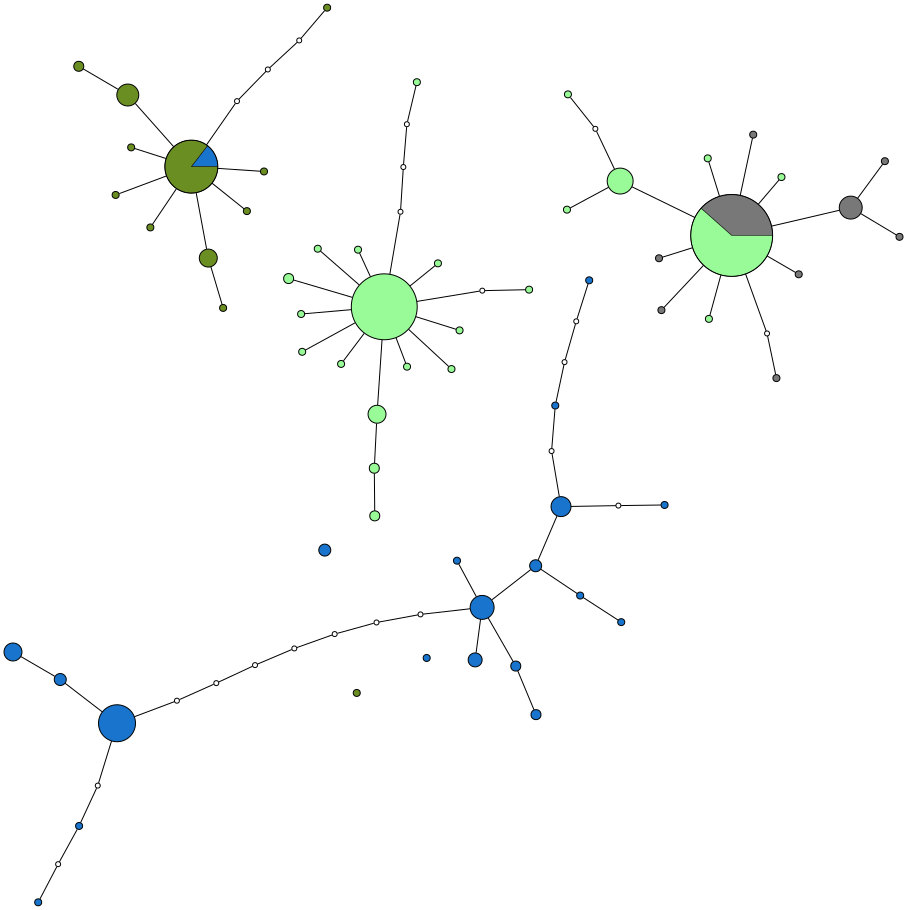

In [29]:
# change the maximum connection distance
graph = graph_haplotype_network(h_vgsc_995S, hap_colors=hap_colors_995S, max_dist=8, show_node_labels=10000)
graph

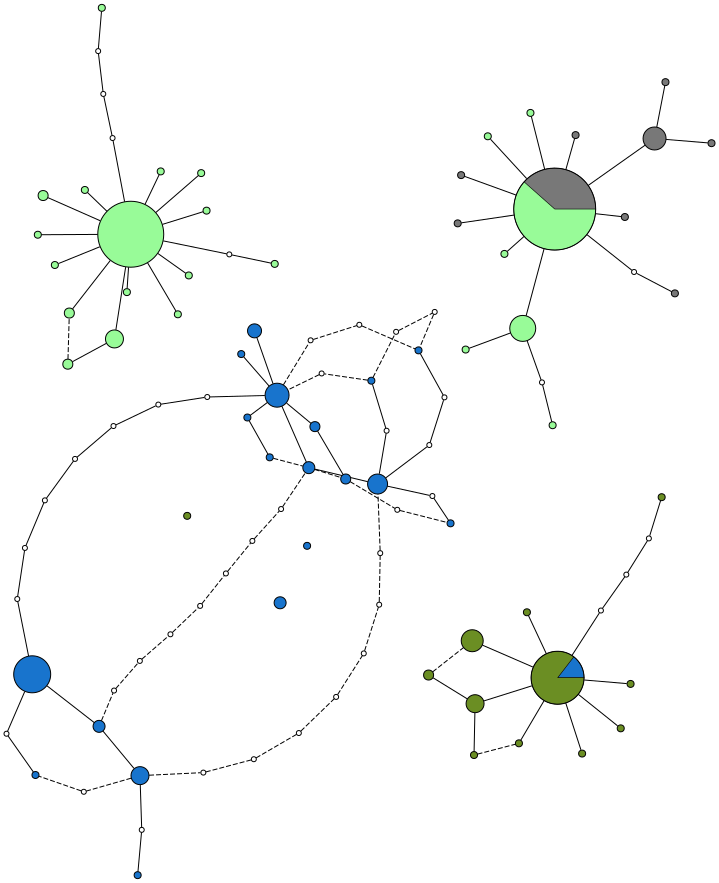

In [30]:
graph = graph_haplotype_network(h_vgsc_995S, hap_colors=hap_colors_995S, network_method='msn', max_dist=10, show_node_labels=10000)
graph

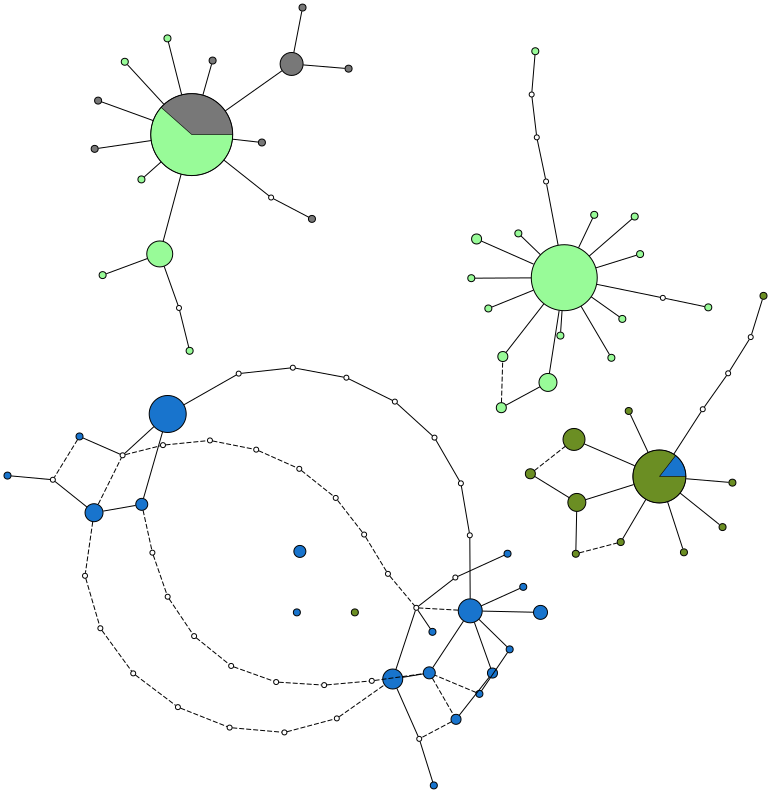

In [31]:
graph = graph_haplotype_network(h_vgsc_995S, hap_colors=hap_colors_995S, network_method='mjn', max_dist=10, show_node_labels=10000)
graph

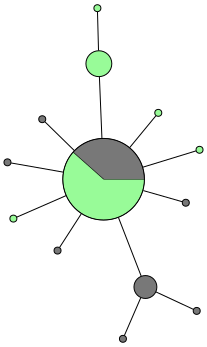

In [32]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 17
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, network_method='msn', show_node_labels=10000)
graph

### add labels

In [33]:
tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
    .eq('num_alleles', 2)
    .cut('POS', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .rename('AGAP004707-RA', 'label')
)
tbl_variant_labels

0|POS,1|label
2358254,D33N
2358316,
2358328,
2358353,
2358405,


In [34]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')
pos2label[pos_995F]

'L995F'

In [35]:
variant_labels = np.array([pos2label.get(p, '') for p in pos], dtype=object)
variant_labels_vgsc = variant_labels[loc]
variant_labels_vgsc[:5]

array(['D33N', '', '', '', ''], dtype=object)

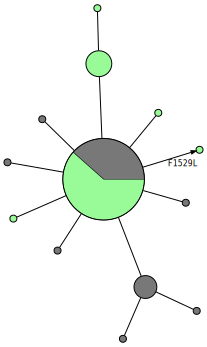

In [36]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 17
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, 
                                mode='KK', edge_weight=100, network_method='msn', 
                                variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)

graph

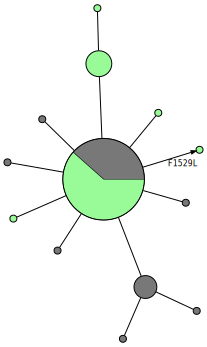

In [37]:
#different method
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, 
                                network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

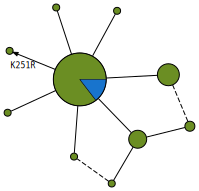

In [38]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 14
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=10, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

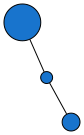

In [39]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=10, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

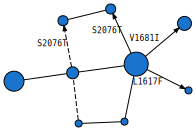

In [40]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 9
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='major', edge_weight=20, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

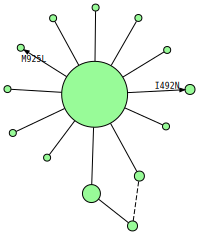

In [41]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 2
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=20, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

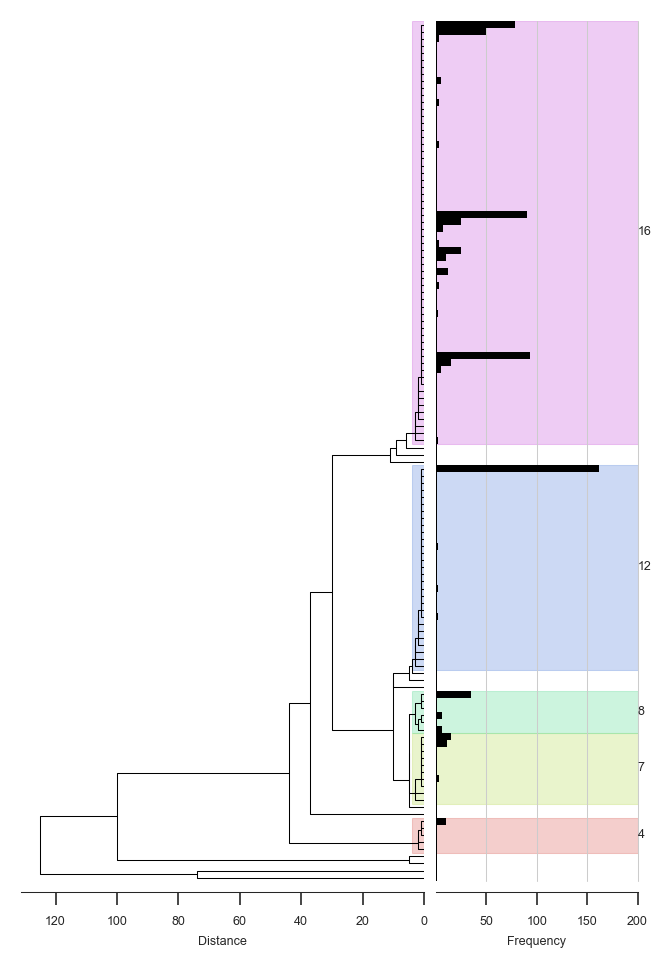

In [42]:
# let's do L995F as well...
figure, ax_dend, ax_freq, cluster_spans_995F, leaf_obs_995F = fig_haplotypes_clustered(h_vgsc_995F, orientation='left', cut_height=4, dpi=150, 
                                                                                    highlight_clusters=5, label_clusters=5)

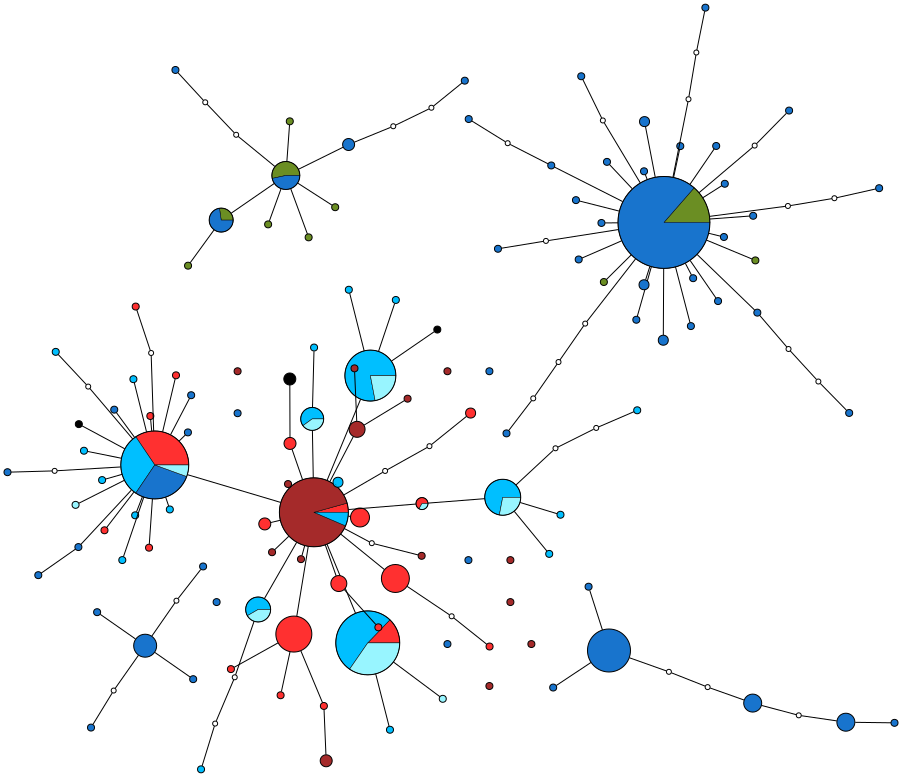

In [43]:
graph = graph_haplotype_network(h_vgsc_995F, 
                                hap_colors=hap_colors_995F,
                                max_dist=4, show_node_labels=10000)
graph

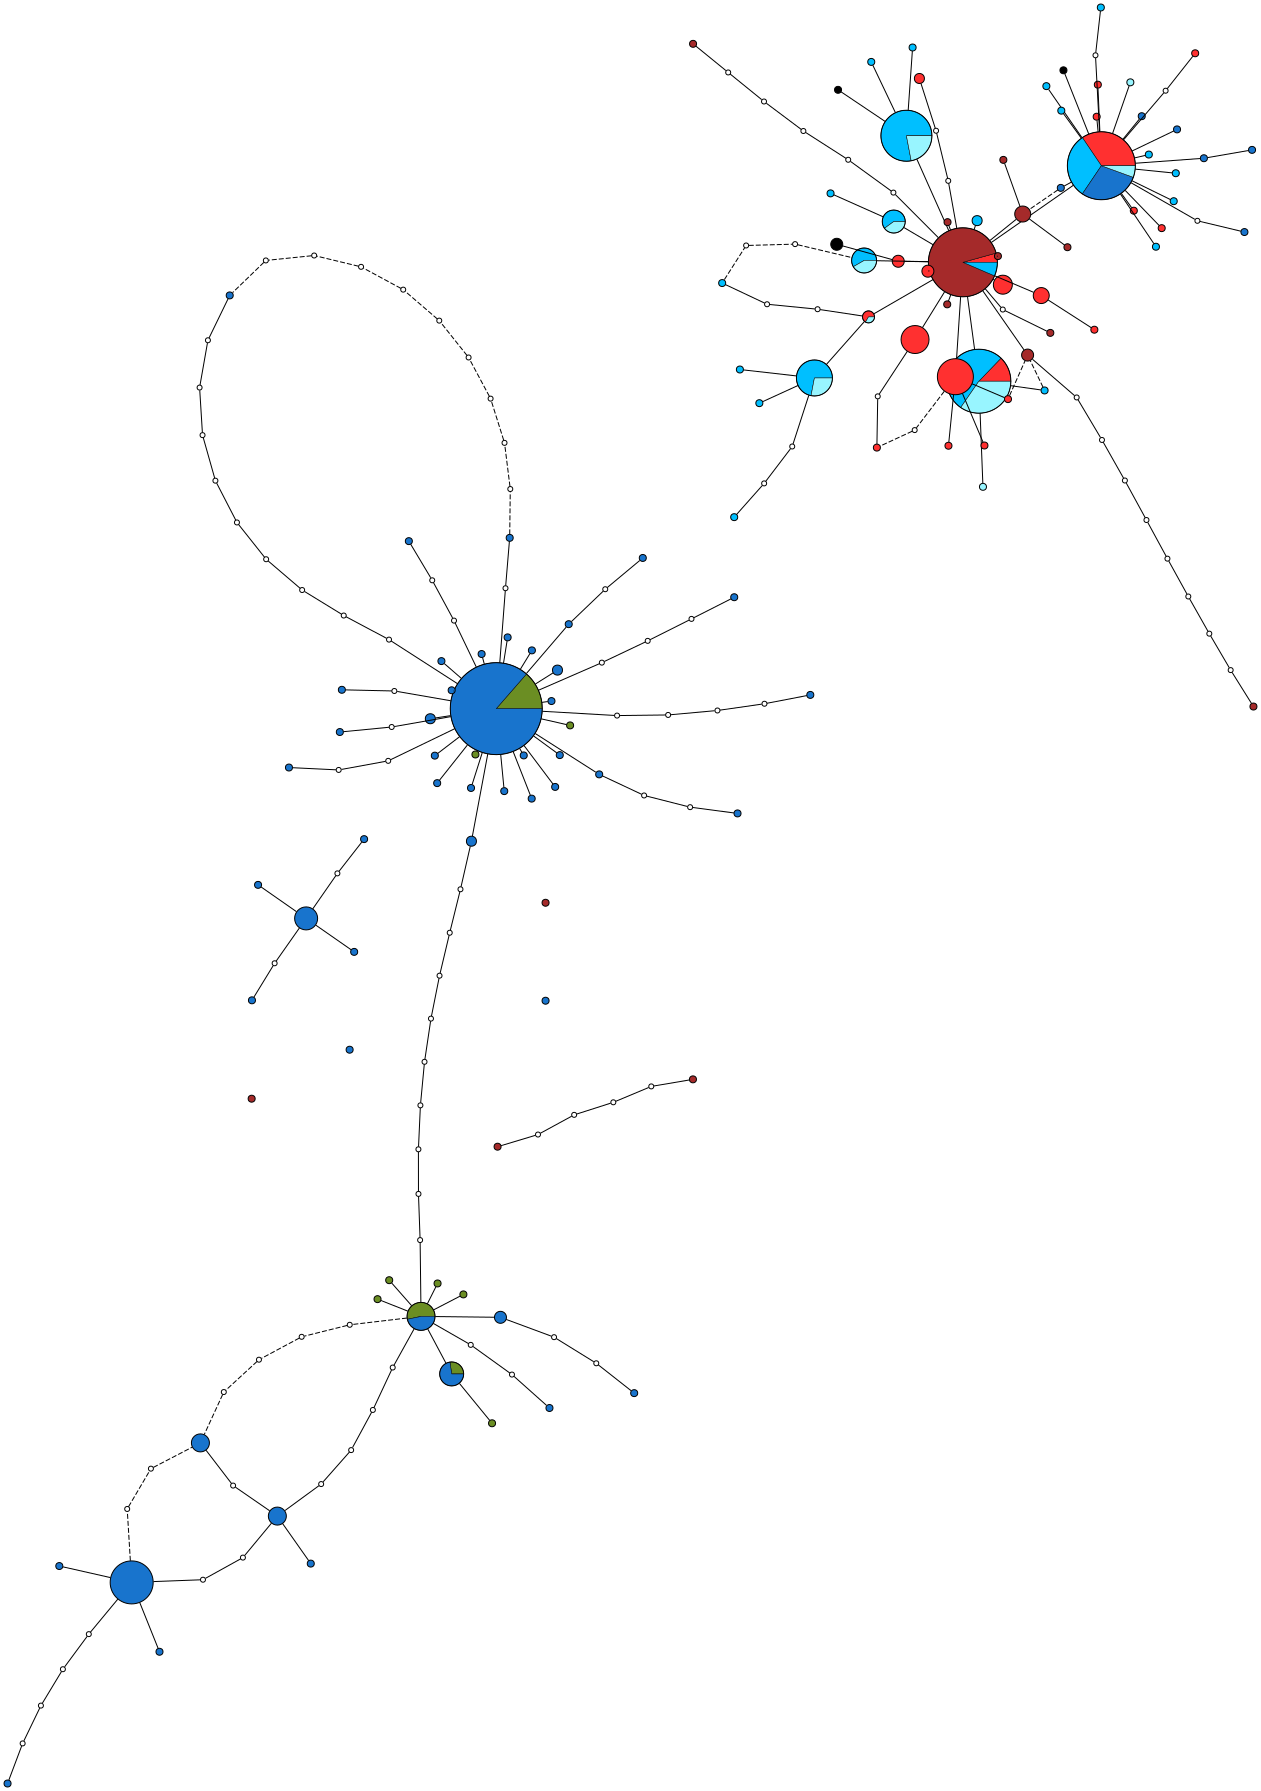

In [44]:
graph = graph_haplotype_network(h_vgsc_995F, hap_colors=hap_colors_995F,
                                max_dist=10, network_method='msn', show_node_labels=10000)
graph

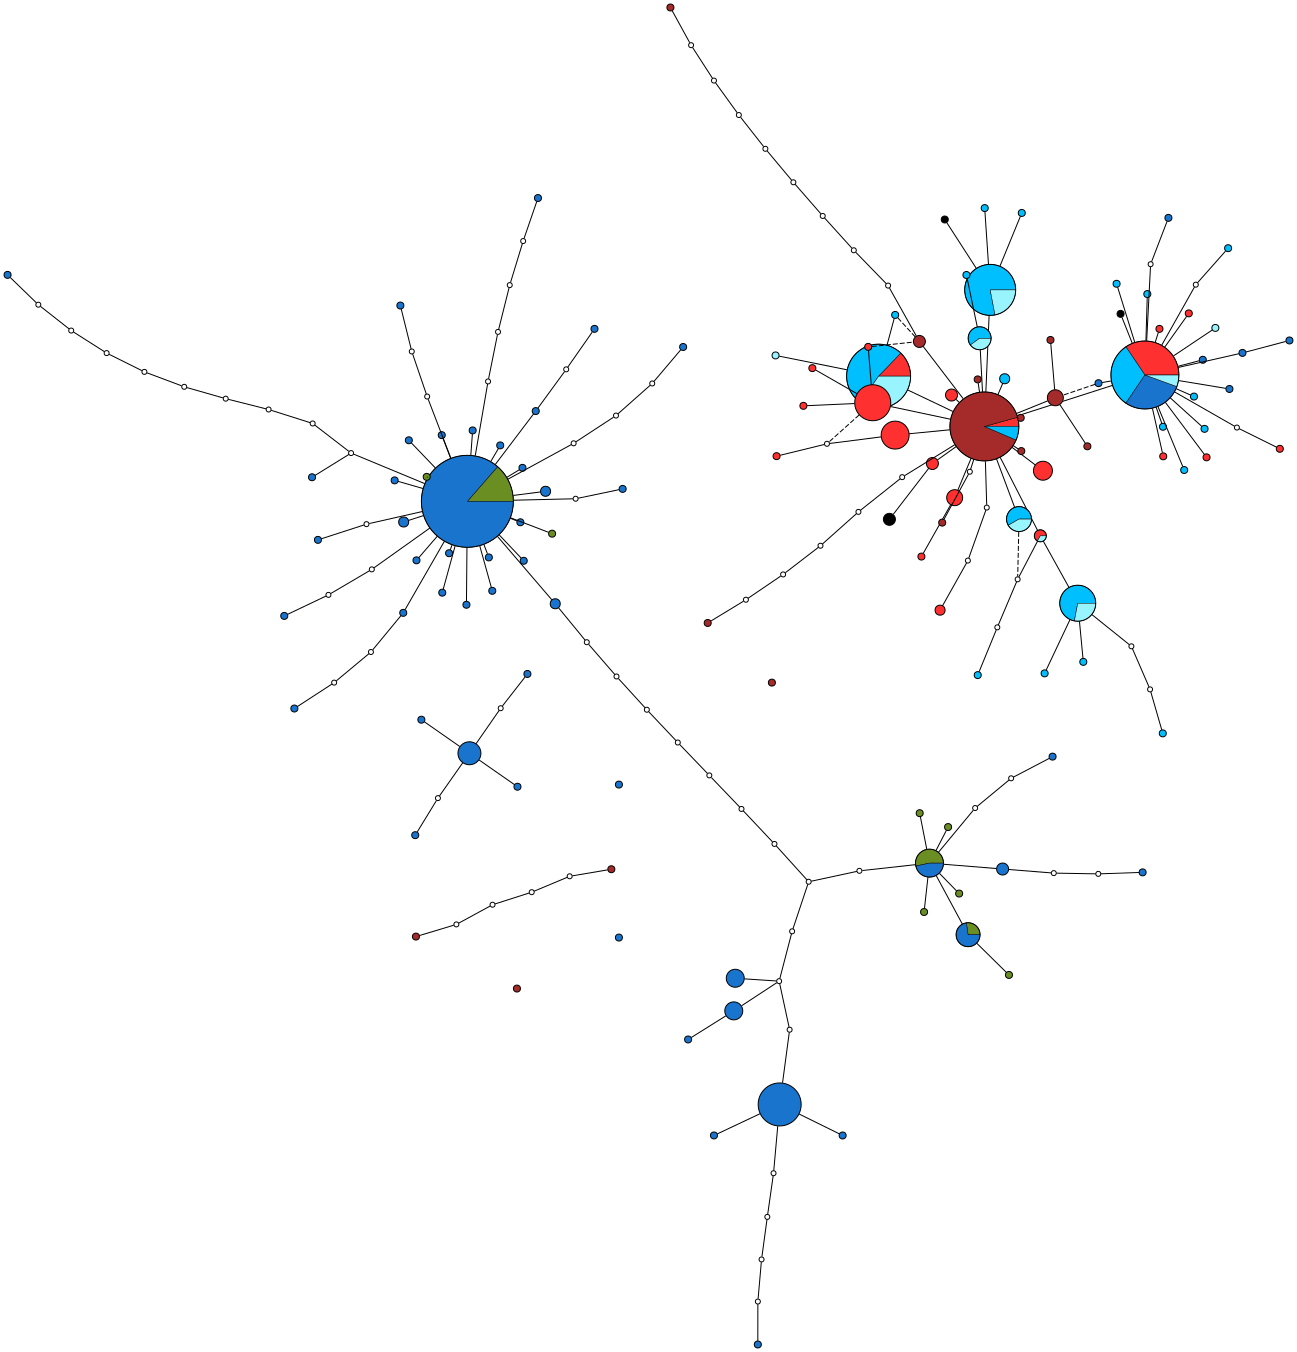

In [45]:
graph = graph_haplotype_network(h_vgsc_995F, hap_colors=hap_colors_995F, max_dist=10, network_method='mjn', show_node_labels=10000)
graph

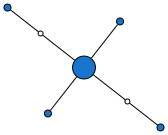

In [46]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 4
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8 , show_node_labels=10000)
graph

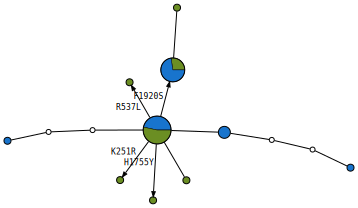

In [47]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 7
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

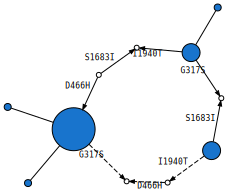

In [48]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 8
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

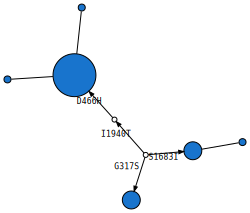

In [49]:
#now this one has some ambiguity, what does it look like under other models?
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, 
                                network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

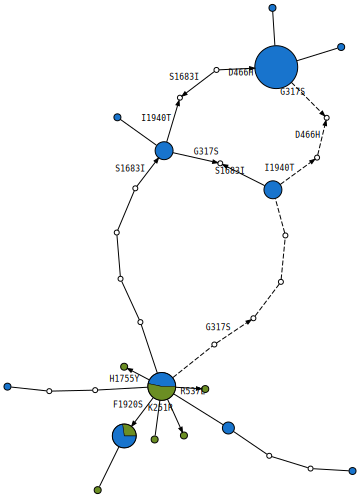

In [50]:
# plot a network for two of the clusters together 
cluster_hap_indices = []
for cluster_idx in 7, 8:
    _, _, cidx = cluster_spans_995F[cluster_idx]
    cluster_hap_indices.extend(cidx)
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

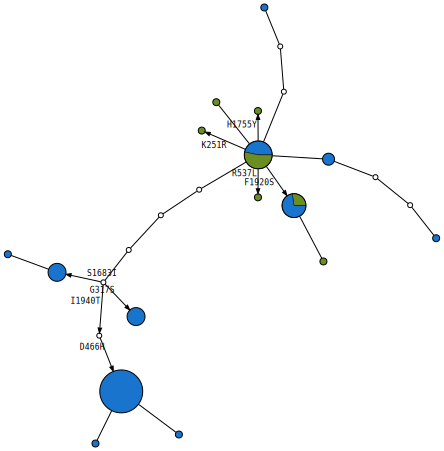

In [51]:
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=100, 
                                network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

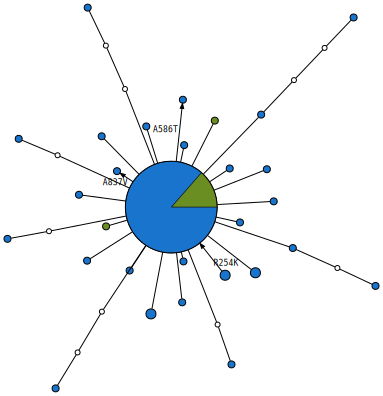

In [52]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', edge_weight=50, 
                                network_method='msn', variant_labels=variant_labels_vgsc, fontsize=8, show_node_labels=10000)
graph

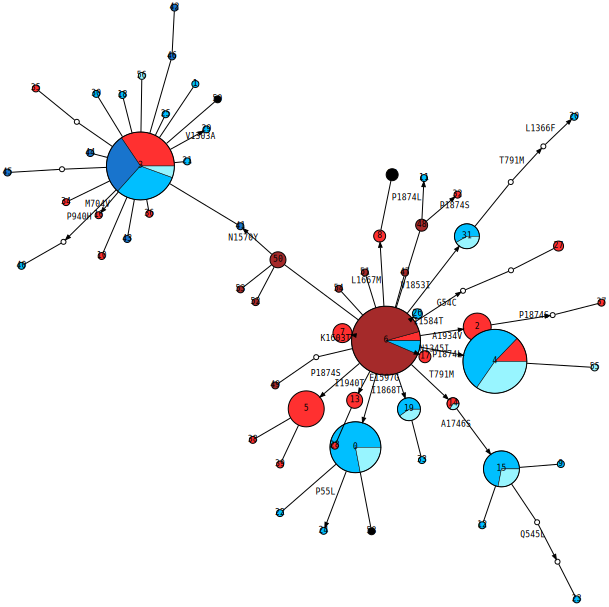

In [53]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                edge_weight=10, overlap='true', splines=False, 
                                show_node_labels=True, variant_labels=variant_labels_vgsc, fontsize=8)
graph

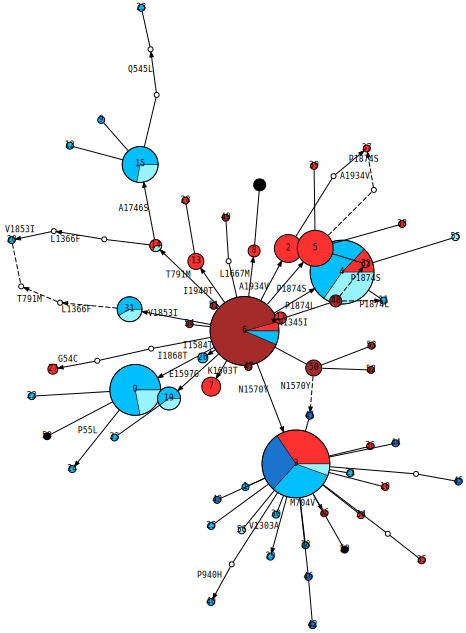

In [54]:
#does the network model matter?
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='msn',
                                edge_weight=10, overlap='true', splines=False, 
                                show_node_labels=True, variant_labels=variant_labels_vgsc, fontsize=8)
graph

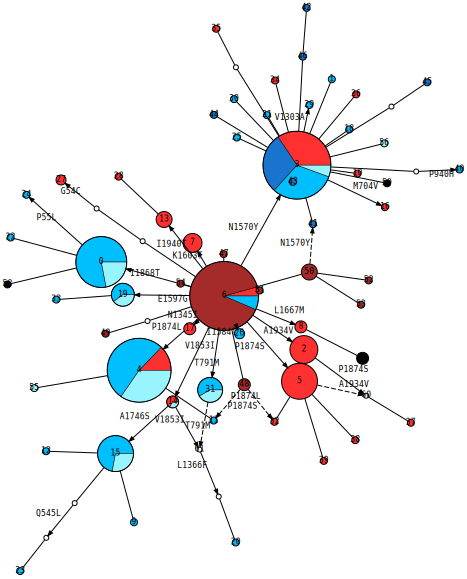

In [55]:
# does the different network method really matter?
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mjn', 
                                edge_weight=8,  overlap=True, splines=False, node_size_factor=0.01,
                                show_node_labels=True, variant_labels=variant_labels_vgsc, fontsize=8)
graph

In [56]:
# ...yes I think it does. 
# E.g., look at where nodes 11 and 16 get placed in the MST versus the MSN.
# E.g., look at how nodes 31, 14 and 20 are connected in the MSN versus the MJN
# E.g., look at how nodes 2, 5 and 37 are connected in the MSN versus the MJN

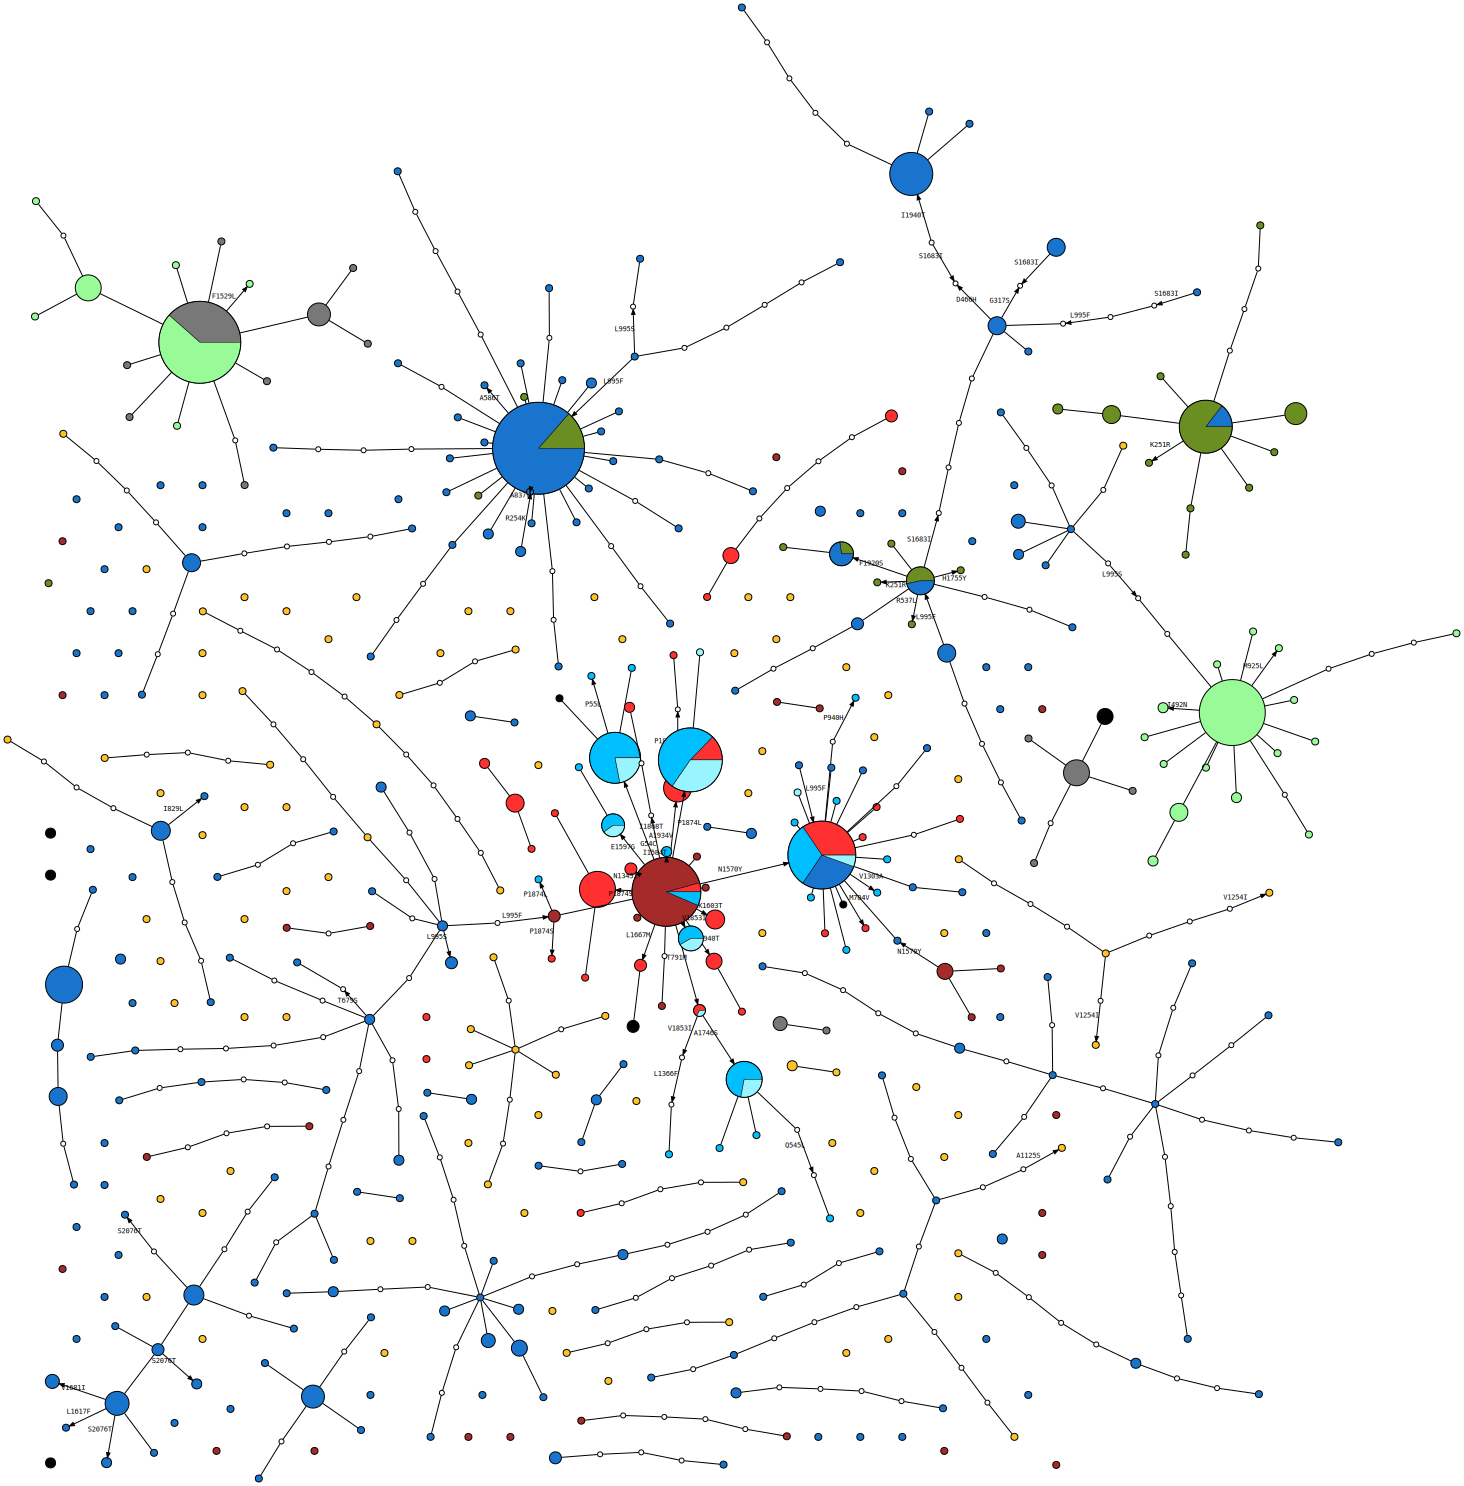

In [57]:
# just for fun, graph the whole lot...
graph = graph_haplotype_network(h_vgsc, hap_colors=hap_colors, network_method='mst', 
                                variant_labels=variant_labels_vgsc, fontsize=7, show_node_labels=10000)
graph

### matplotlib integration

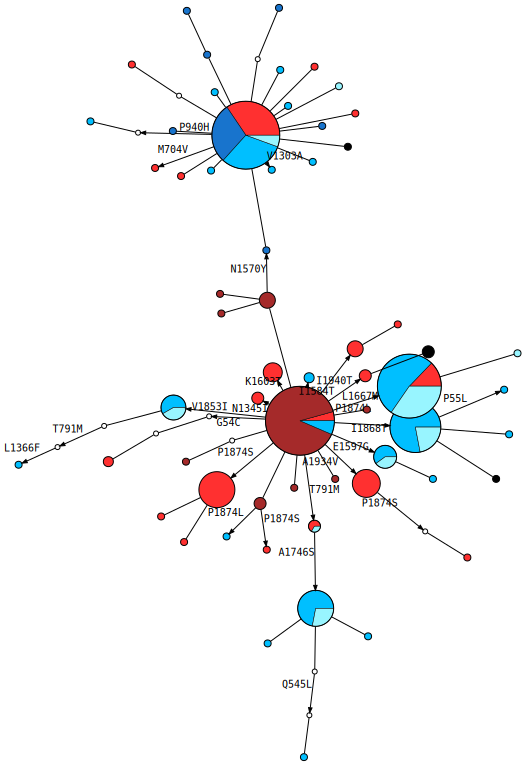

In [58]:
#generate a 'graph'
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph1 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                edge_weight=12, overlap='true', splines=False, 
                                show_node_labels=10000, fontsize='10', variant_labels=variant_labels_vgsc)
graph1

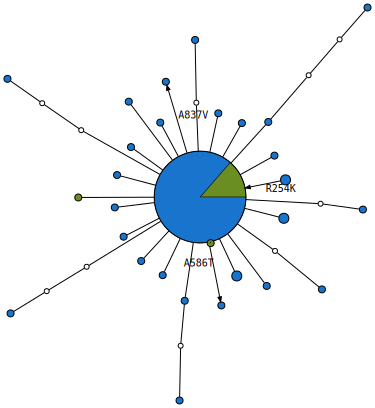

In [59]:
#generate a 'graph'
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph2 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                edge_weight=12, overlap='true', splines=False, 
                                show_node_labels=10000, fontsize='10', variant_labels=variant_labels_vgsc)
graph2

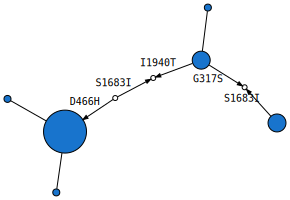

In [60]:
#generate a 'graph'
cluster_idx = 8
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph3 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                edge_weight=12, overlap='true', splines=False, 
                                show_node_labels=10000, fontsize='10', variant_labels=variant_labels_vgsc)
graph3

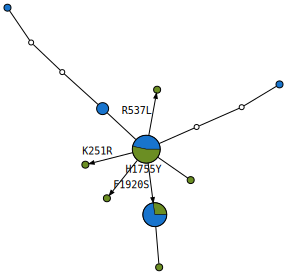

In [61]:
#generate a 'graph'
cluster_idx = 7
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph4 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                edge_weight=12, overlap='true', splines=False, 
                                show_node_labels=10000, fontsize='10', variant_labels=variant_labels_vgsc)
graph4

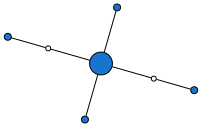

In [62]:
#generate a 'graph'
cluster_idx = 4
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph5 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                edge_weight=12, overlap='true', splines=False, 
                                show_node_labels=10000, fontsize='10', variant_labels=variant_labels_vgsc)
graph5

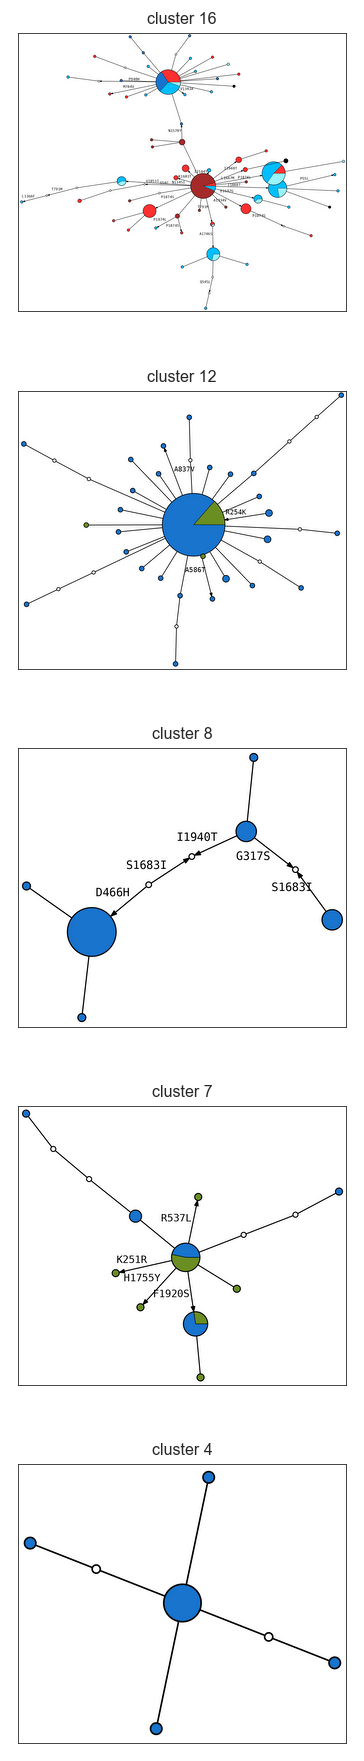

In [63]:
fig = plt.figure(figsize=(3, 15), dpi=120)

ax = fig.add_subplot(5, 1, 1)
# leave frame around to allow comparison with ratio='fill' below
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('cluster 16')
plot_gv(graph1, ax, dpi=600, interpolation='lanczos', ratio='fill')

ax = fig.add_subplot(5, 1, 2)
# leave frame around to allow comparison with ratio='fill' below
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('cluster 12')
plot_gv(graph2, ax, dpi=600, interpolation='lanczos', ratio='fill')

ax = fig.add_subplot(5, 1, 3)
# leave frame around to allow comparison with ratio='fill' below
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('cluster 8')
plot_gv(graph3, ax, dpi=600, interpolation='lanczos', ratio='fill')

ax = fig.add_subplot(5, 1, 4)
# leave frame around to allow comparison with ratio='fill' below
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('cluster 7')
plot_gv(graph4, ax, dpi=600, interpolation='lanczos', ratio='fill')

ax = fig.add_subplot(5, 1, 5)
# leave frame around to allow comparison with ratio='fill' below
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('cluster 4')
plot_gv(graph5, ax, dpi=600, interpolation='lanczos', ratio='fill')


fig.tight_layout()

In [64]:
def plot_clus(graph, ax, axis=False, title=None):
    if axis == False:
        ax.set_axis_off()
    if title != None:
        ax.set_title(title)
    plot_gv(graph, ax, dpi=600, interpolation='lanczos', ratio='fill')

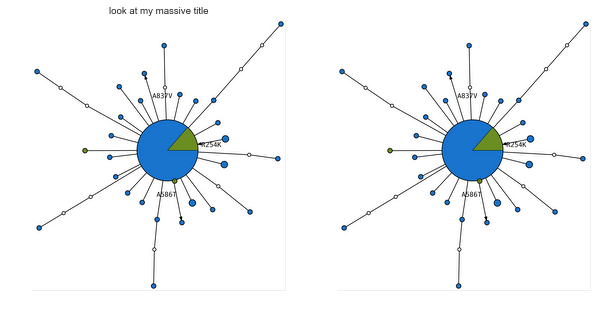

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.subplot(1,2,1)
plot_clus(graph2, ax, title='look at my massive title')
ax = plt.subplot(1,2,2)
plot_clus(graph2, ax)

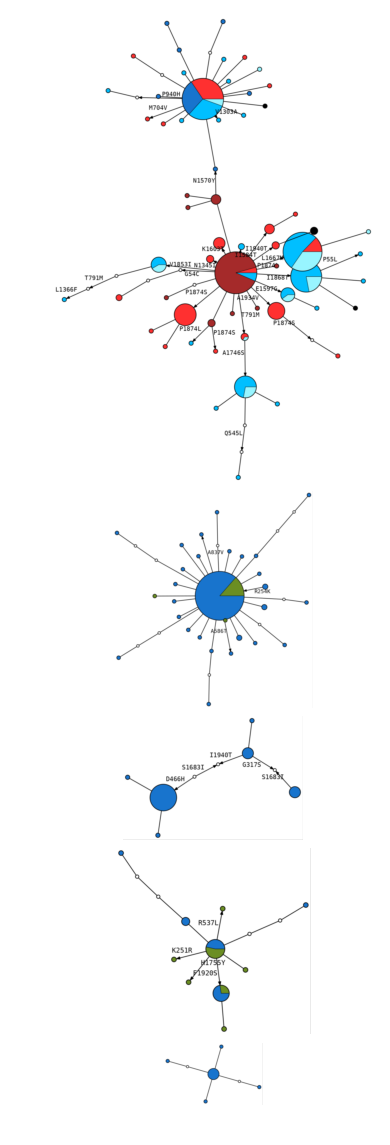

In [66]:
# use gridspec to scale size of each plot
fig = plt.figure(figsize=(4, 12), dpi=120)

# define subplot layout
gs_nrows = 5
gs_ncols = 1
height_ratios=(7.5, 3.5, 2, 3,1)
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04 , wspace=0.04, height_ratios=height_ratios)

# networks
ax = fig.add_subplot(gs[0, 0])
ax.set_axis_off()
plot_gv(graph1, ax, dpi=600)

ax = fig.add_subplot(gs[1, 0])
ax.set_axis_off()
plot_gv(graph2, ax, dpi=600)

ax = fig.add_subplot(gs[2, 0])
ax.set_axis_off()
plot_gv(graph3, ax, dpi=600)

ax = fig.add_subplot(gs[3, 0])
ax.set_axis_off()
plot_gv(graph4, ax, dpi=600)

ax = fig.add_subplot(gs[4, 0])
ax.set_axis_off()
plot_gv(graph5, ax, dpi=600)

## Hmmm, neither looking too awesome, how do they look alongside the dendrogram?
- first work out how to use 'ax' properly to get dendro and clusters together!

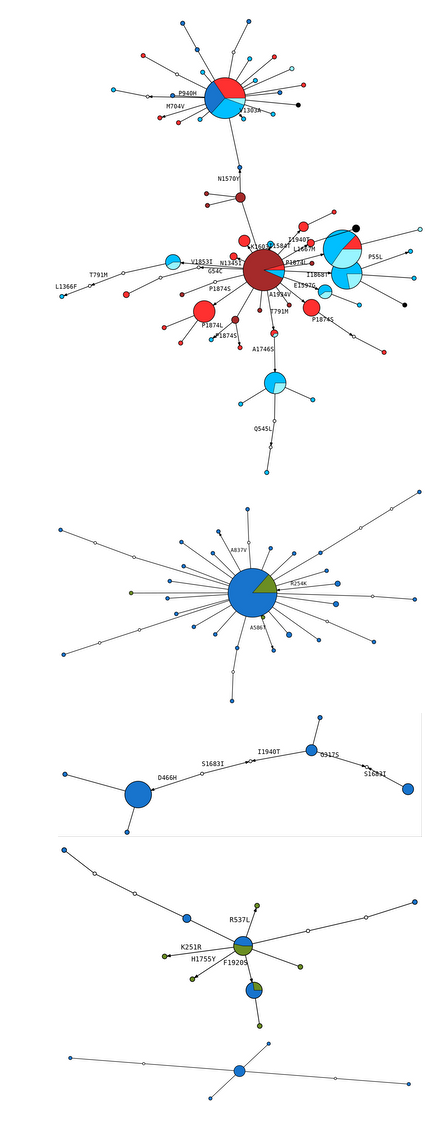

In [67]:
# use gridspec to scale size of each plot
fig = plt.figure(figsize=(4, 12), dpi=120)

# define subplot layout
gs_nrows = 5
gs_ncols = 1
height_ratios=(7.5, 3.5, 2, 3,1)
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04 , wspace=0.04, height_ratios=height_ratios)

# networks
ax = fig.add_subplot(gs[0, 0])
#ax.set_axis_off()
plot_clus(graph1, ax)

ax = fig.add_subplot(gs[1, 0])
#ax.set_axis_off()
plot_clus(graph2, ax)

ax = fig.add_subplot(gs[2, 0])
#ax.set_axis_off()
plot_clus(graph3, ax)

ax = fig.add_subplot(gs[3, 0])
#ax.set_axis_off()
plot_clus(graph4, ax)

ax = fig.add_subplot(gs[4, 0])
#ax.set_axis_off()
plot_clus(graph5, ax)

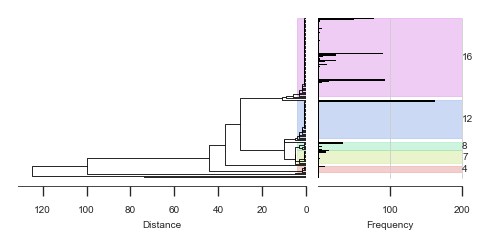

In [68]:
fig = plt.figure(figsize=(4, 2), dpi=120)
_, _, _, _, _ = fig_haplotypes_clustered(h_vgsc_995F, 
                                       orientation='left', cut_height=4, dpi=150, 
                                       highlight_clusters=5, label_clusters=5, fig=fig)

### the problem i'm having is that fig_haplotypes_clustered is built from subplots, so I need to nest these subplots within my dendro/net subplots.

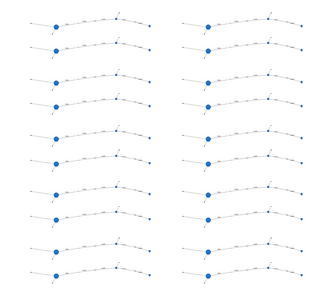

In [69]:
fig = plt.figure(figsize=(5, 5))
#here we have a 2 x 5 outer grid left to right 0,1,2,3...
outer = mpl.gridspec.GridSpec(5, 2, wspace=0.2, hspace=0.2)

#for the 10 outer grids
for i in range(10):
    
    #generate an inner grid
    inner = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    #for each of the two inner grids, do something
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        fig.add_subplot(ax)
        plot_clus(graph3, ax)

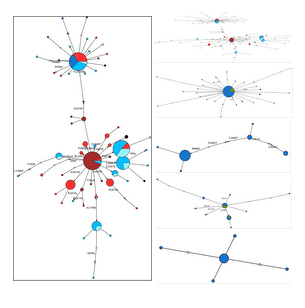

In [70]:
#okay, that kinda of worked, so we actually want one row, two columns, first for dendro, second column having 5 sub rows for the clusters

cluster_dic = {0:graph1,
               1:graph2,
               2:graph3,
               3:graph4,
               4:graph5}



fig = plt.figure(figsize=(5, 5))
#here we have a 2 x 1 outer grid left to right 0, 1...
outer = mpl.gridspec.GridSpec(1, 2, wspace=0.02, hspace=0.02)


#generate an inner grid
inner1 = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.1)
ax = plt.Subplot(fig, inner1[0])
fig.add_subplot(ax)
ax.set_xticks([])
ax.set_yticks([])
plot_clus(graph1, ax, axis=True)

#generate an inner grid
inner2 = mpl.gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
#for each of the inner grids, do something
for j in range(5):
    ax = plt.Subplot(fig, inner2[j])
    fig.add_subplot(ax)
    plot_clus(cluster_dic[j], ax)

In [71]:
#hmmm, something like that but where the left hand panel is dendro fun...

### still have the problem of trying to get an 'ax' option into the dendro code. Perhaps it is easier to add the clusters into this code?
- start with the function from hapclust_utils
- or turn output into png like cluster

In [72]:
def fig_haplotypes_test(h,
                        distance_metric='hamming',
                        linkage_method='single',
                        truncate_distance=0,
                        orientation='left',
                        subplot_ratios=(4, 2, 2),
                        subplot_pad=0,
                        despine_offset=5,
                        count_sort=True,
                        dend_linecolor='k',
                        cut_height=2,
                        highlight_clusters=True,
                        highlight_colors=None,
                        highlight_dend=True,
                        highlight_freq=True,
                        highlight_alpha=0.3,
                        label_clusters=True,
                        dpi=None,
                             fig=None,
                             ):

    
    # check inputs
    h = allel.HaplotypeArray(h)
    
    # compute distance matrix
    dist = scipy.spatial.distance.pdist(h.T, metric=distance_metric)
    if distance_metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= h.n_variants
    
    # compute hierarchical clustering
    Z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    # find level to truncate dendrogram
    lastp = h.n_haplotypes - bisect.bisect_right(Z[:, 2], truncate_distance)
    
    # convenience variables
    horizontal = orientation in ['left', 'right']
    
    # setup figure
    if fig is None:
        figsize = plt.rcParams['figure.figsize']
        if horizontal:
            figsize = figsize[::-1]
        fig = plt.figure(figsize=figsize, dpi=dpi)
        
    # setup gridspec and axes

    height_ratios=(12, 5, 0.7, 2.5, 0.7)
    gs = plt.GridSpec(nrows=5, ncols=3, height_ratios=height_ratios, width_ratios=subplot_ratios)

    ax_dend = fig.add_subplot(gs[:,0])
    ax_freq = fig.add_subplot(gs[:,1])

    ax_c1 = fig.add_subplot(gs[0,2])
    ax_c2 = fig.add_subplot(gs[1,2])
    ax_c3 = fig.add_subplot(gs[2,2])
    ax_c4 = fig.add_subplot(gs[3,2])
    ax_c5 = fig.add_subplot(gs[4,2])
    
    

    sns.despine(ax=ax_dend, offset=despine_offset, left=True, top=True, right=True, bottom=False)
    sns.despine(ax=ax_freq, offset=despine_offset, left=True, top=True, right=True, bottom=False)
    sns.despine(ax=ax_c1, offset=despine_offset, left=True, top=True, right=True, bottom=True)
    sns.despine(ax=ax_c2, offset=despine_offset, left=True, top=True, right=True, bottom=True)
    sns.despine(ax=ax_c3, offset=despine_offset, left=True, top=True, right=True, bottom=True)
    sns.despine(ax=ax_c4, offset=despine_offset, left=True, top=True, right=True, bottom=True)
    sns.despine(ax=ax_c5, offset=despine_offset, left=True, top=True, right=True, bottom=True)


    # make a dendrogram
    kwargs_dend = dict(
        truncate_mode='lastp', 
        p=lastp,
        show_leaf_counts=False, 
        count_sort=count_sort, 
        no_labels=True, 
        color_threshold=0, 
        above_threshold_color=dend_linecolor, 
        orientation=orientation
    )    
    dend = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_dend, **kwargs_dend)
    leaves = dend['leaves']
    ax_dend_label = 'Distance'

    ax_dend.set_xlabel(ax_dend_label)
    ax_dend.set_yticks([])
        
    # construct a tree and compute observation counts for the dendrogram leaves
    tree = scipy.cluster.hierarchy.to_tree(Z)
    s = np.arange(len(leaves))
    t = np.array([
        1 if l < h.n_haplotypes
        else tree.get_descendant(l).get_count()
        for l in leaves
    ])

    # plot frequencies bar
    ax_freq_label = 'Frequency'

    ax_freq.barh(s, t, height=1, lw=0, color='k', align='edge')
    ax_freq.set_ylim(0, len(leaves))
    ax_freq.set_yticks([])
    ax_freq.set_xlabel(ax_freq_label)
    ax_freq.grid(axis='x', lw=.5)
    if orientation == 'right':
        ax_freq.invert_xaxis()
    # remove 0
    ax_freq.set_xticks(ax_freq.get_xticks()[1:])
    
    #plot networks
    plot_clus(cluster_dic[0], ax_c1, title='Cluster 16')
    plot_clus(cluster_dic[1], ax_c2, title='Cluster 12')
    plot_clus(cluster_dic[2], ax_c3, title='Cluster 8')
    plot_clus(cluster_dic[3], ax_c4, title='Cluster 7')
    plot_clus(cluster_dic[4], ax_c5, title='Cluster 4')
    

    # cut the tree
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # now the fiddly bit - we need to figure out where the clusters have
    # ended up in the dendrogram we plotted earlier...
    
    # N.B., the dendrogram was truncated, so each leaf in the dendrogram
    # may correspond to more than one original observation (i.e., haplotype).
    # Let's build a list storing the observations for each leaf:
    leaf_obs = [tree.get_descendant(ix).pre_order() for ix in leaves]
    
    # Now let's figure out for each leaf in the dendrogram, which of the clusters
    # obtained by cutting the tree earlier does it fall into?
    leaf_clusters = np.array([cut[l[0]] for l in leaf_obs])
    
    # Now let's build a data structure that reorders the clusters so they
    # occur in the same order as in the dendrogram, and also record the indices
    # of the start and stop leaf for each cluster:
    cluster_spans = list()
    c_prv = leaf_clusters[0]
    i_start = 0
    for i, c in enumerate(leaf_clusters[1:], 1):
        if c != c_prv:
            cluster_spans.append((i_start, i, clusters[c_prv]))
            i_start = i
        c_prv = c
    # don't forget the last one
    cluster_spans.append((i_start, i+1, clusters[c]))
    
    # OK, now figure out which clusters we want to highlight...
    if isinstance(highlight_clusters, (list, tuple)):
        # user has manually specified which clusters to highlight
        pass
    else:
        # assume highlight_clusters is the minimum cluster size to highlight
        min_cluster_size = int(highlight_clusters)
        highlight_clusters = [i for i, cs in enumerate(cluster_spans) 
                              if len(cs[2]) >= min_cluster_size]
        
    # setup colors for highlighting clusters
    if highlight_colors is None:
        highlight_colors = sns.color_palette('hls', n_colors=len(highlight_clusters))
    

        
    # do the highlighting
    for color, cix in zip(highlight_colors, highlight_clusters):
        start, stop, _ = cluster_spans[cix]
        freq_spanf = ax_freq.axhspan
        dend_patch_xy = (0, start * 10)
        dend_patch_width = cut_height
        dend_patch_height = (stop - start) * 10
        if highlight_freq:
            freq_spanf(start, stop, color=color, alpha=highlight_alpha, zorder=-20)
        if highlight_dend:
            ax_dend.add_patch(plt.Rectangle(xy=dend_patch_xy, 
                                            width=dend_patch_width, 
                                            height=dend_patch_height, 
                                            color=color, alpha=highlight_alpha, 
                                            zorder=-20))
            
            
        

    # for debugging, label the clusters
    if label_clusters:
        for i, (start, stop, clst) in enumerate(cluster_spans):
            if horizontal:
                x = max(ax_freq.get_xlim())
                y = (start + stop) / 2
                ha = orientation
                va = 'center'
            else:
                x = (start + stop) / 2
                y = max(ax_freq.get_ylim())
                ha = 'center'
                va = orientation
            # treat label_clusters as minimum cluster size to label
            if len(clst) >= int(label_clusters):
                ax_freq.text(x, y, str(i), 
                             va=va, ha=ha, fontsize=6)
    
    # tidy up plot

    gs.tight_layout(fig, w_pad=subplot_pad)
    
    
    #can we overlay colours on cluster plots
    ax_c1.add_patch(patches.Rectangle(
        (1, 1),   # (x,y)
        1,          # width
        1)          # height
    )
    
    
    
    fig.savefig('test_fig.pdf', )

    
    # return some useful stuff
    return fig, ax_dend, ax_freq, cluster_spans, leaf_obs


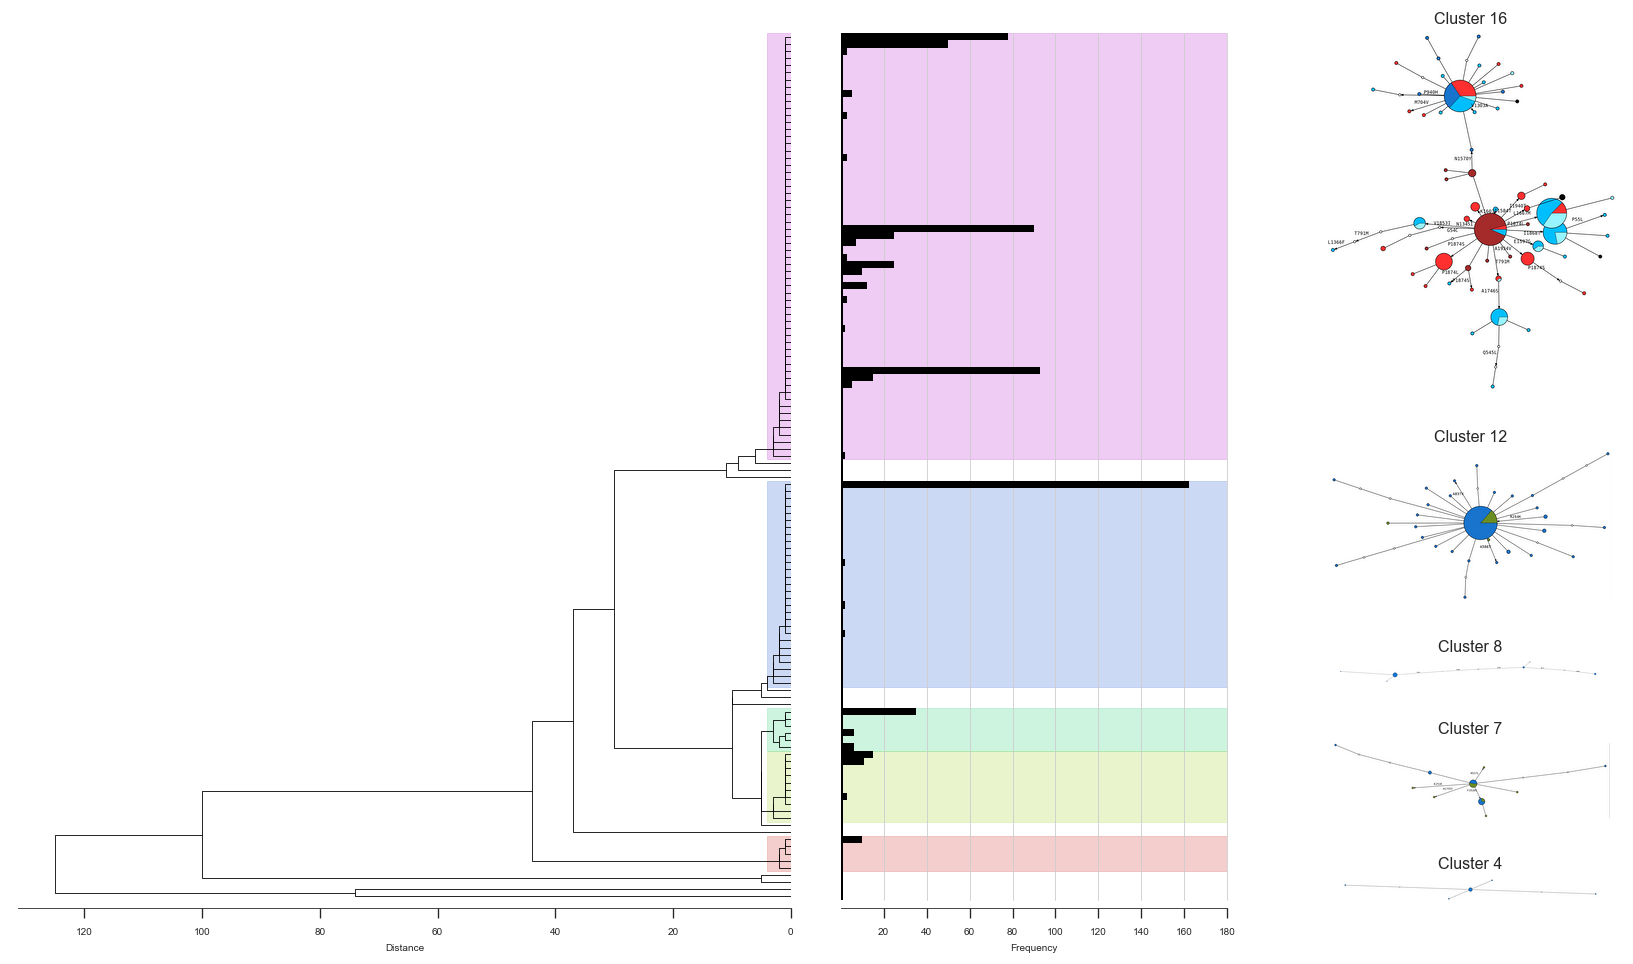

In [73]:
fig = plt.figure(figsize=(14, 8), dpi=120)
_, _, _, _, _ = fig_haplotypes_test(h_vgsc_995F, 
                                       orientation='left', cut_height=4, dpi=150, 
                                       highlight_clusters=5, label_clusters=False, fig=fig)

### seems to be difficult to add colour to the networks - maybe down to the image array that we used to get the graph viz into matplotlib
### Can we kick out the graphviz networks in a vector format and build figure in inkscape?
- scale edges so theyre all clear
- maybe simplify the networks - use larger specific figures to label mutations etc
- remove colonies?

In [74]:
#generate 995f svgs

def svg_f(idx):
    cluster_idx = idx
    dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
    cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
    cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
    cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
    graph1 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                    edge_weight=12, overlap='true', splines=False, 
                                    show_node_labels=10000, fontsize='10')
    graph1.format = 'svg'
    fn = '995F_cluster_'+str(idx)
    graph1.render(fn)

In [75]:
for g in 16, 12, 8, 7, 4:
    svg_f(g)

In [76]:
#REMOVE COLONIES...

In [77]:
#add bg colour to plot
#tried adding it as bgcolor in the graphviz bit of hapclust_utils - didn't work - try again.

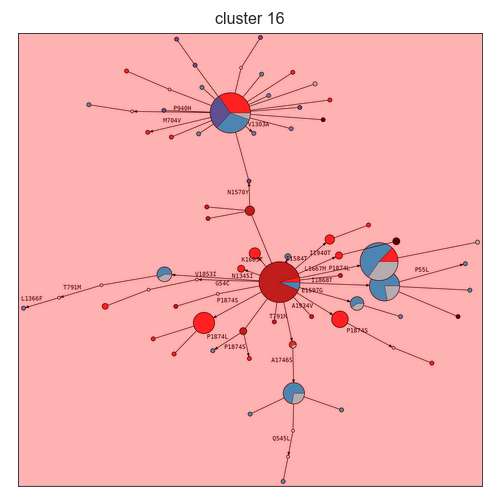

In [78]:
fig = plt.figure(figsize=(5, 5), dpi=120)

ax = fig.add_subplot(1, 1, 1)


ax.add_patch(patches.Rectangle((0, 0), 5000, 6000, color='r', alpha=0.3, zorder=1));
# leave frame around to allow comparison with ratio='fill' below
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('cluster 16')
plot_gv(graph1, ax, dpi=600, interpolation='lanczos', ratio='fill');

In [79]:
#okay, this works but it puts it over the top of the network so makes it hard to see the colours, zorder doesn't help becuase the network bg defaults to white
#not transparent..

In [80]:
#try adding bgcolor to the graphviz code in hapclust_utils instead (or set bg to transparent)
#UPDATE - I can't seem to make bgcolor work, nor find any instructions online other than this (http://www.graphviz.org/doc/info/attrs.html#d:bgcolor)
# - leave it for now.

#### make the stand alone cluster 16 for the ms

In [81]:
#generate a 'graph'
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph16 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                  edge_weight=12, overlap=True, splines=False, 
                                  show_node_labels=10000, fontsize='16', variant_labels=variant_labels_vgsc)

# fig = plt.figure(figsize=(5, 5), dpi=120)
# ax = fig.add_subplot(1, 1, 1)

# # leave frame around to allow comparison with ratio='fill' below
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_title('cluster 16')
# plot_gv(graph16, ax, dpi=600, interpolation='lanczos', ratio='fill');

graph16.format = 'svg'
fn = '995F_cluster_16_standalone'
graph16.render(fn)

'995F_cluster_16_standalone.svg'

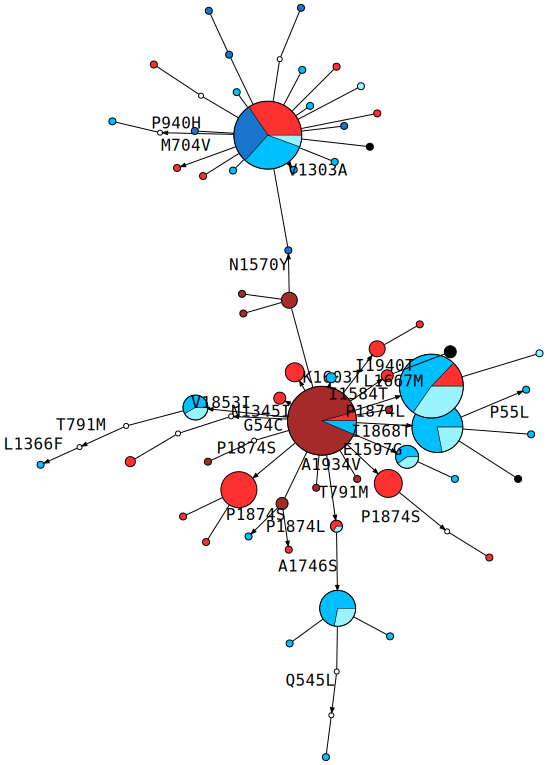

In [85]:
#generate a 'graph'
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph16 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', network_method='mst',
                                                                                                   edge_weight=12, overlap=True, splines=False,
                                                                                                   show_node_labels=10000, fontsize='16', variant_labels=variant_labels_vgsc)
graph16

In [336]:
#use this from graph_haplotype_networks to work out the node size key - need to get is from hapclust_utils
hap_counts

NameError: name 'hap_counts' is not defined

# Change of tack
- table 1 = completed
- figure 1 = two panel dendrogram and freq for a) 995F and b) 995S
- figure 2 = two panel figure of networks, all to scale, kick out all F/S in one figure (MJN network) cut appropriately then arrange in inkscape - retains scale
- figure 3 = based on https://github.com/wtchg-kwiatkowski/ag1000g-paper1/blob/master/notebooks/artwork_ehh_revised.ipynb AM will work on.

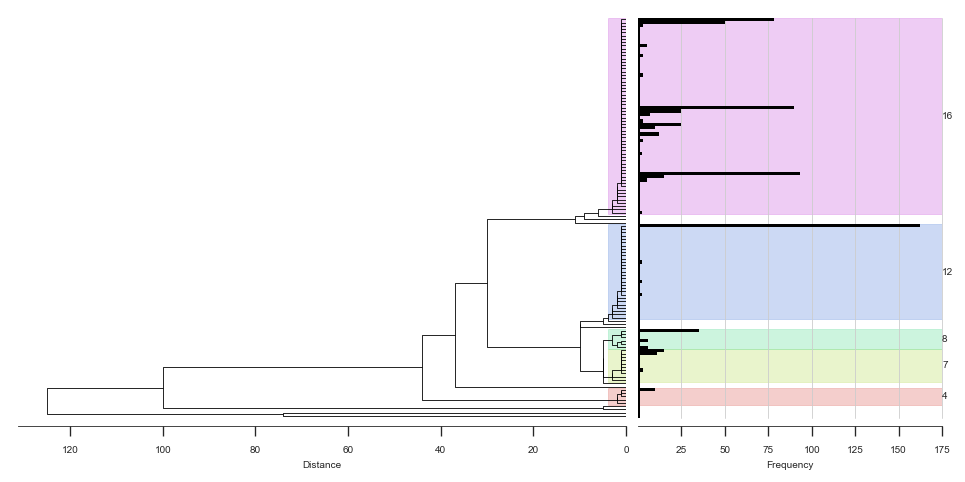

In [114]:
fig = plt.figure(figsize=(8, 4), dpi=120)
_, _, _, _, _ = fig_haplotypes_clustered(h_vgsc_995F, 
                                       orientation='left', cut_height=4, dpi=150, 
                                       highlight_clusters=5, label_clusters=5, fig=fig)

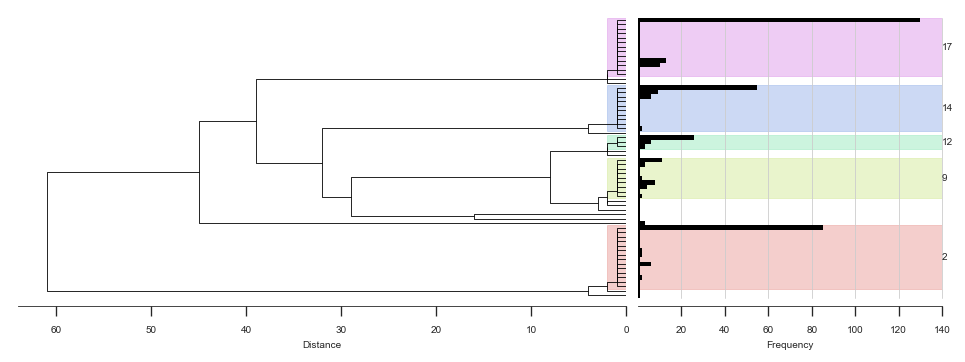

In [94]:
fig = plt.figure(figsize=(8, 3), dpi=120)
_, _, _, _, _ = fig_haplotypes_clustered(h_vgsc_995S, 
                                       orientation='left', dpi=150, 
                                       highlight_clusters=5, label_clusters=5, fig=fig)

## we could have two separate panels (with different axis) or put them both on one Distance/Freq axis to highlight the differences

In [325]:
#altered fig_haplotypes_clustered function to feed in the gridspec axis externally - this allows us to have multiple plots in one figure
def fig_haplotypes_clustered_piffle(h,
                                    ax_dend,
                                    ax_freq,
                                    distance_metric='hamming',
                                    linkage_method='single',
                                    truncate_distance=0,
                                    orientation='top',
                                    subplot_ratios=(4, 2),
                                    subplot_pad=0,
                                    despine_offset=5,
                                    count_sort=True,
                                    dend_linecolor='k',
                                    cut_height=2,
                                    highlight_clusters=True,
                                    highlight_colors=None,
                                    highlight_dend=True,
                                    highlight_freq=True,
                                    highlight_alpha=0.3,
                                    label_clusters=True,
                                    dpi=None):

    
    # check inputs
    h = allel.HaplotypeArray(h)
    
    # compute distance matrix
    dist = scipy.spatial.distance.pdist(h.T, metric=distance_metric)
    if distance_metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= h.n_variants
    
    # compute hierarchical clustering
    Z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)
    
    # find level to truncate dendrogram
    lastp = h.n_haplotypes - bisect.bisect_right(Z[:, 2], truncate_distance)
    
    # convenience variables
    horizontal = orientation in ['left', 'right']
    vertical = not horizontal
    inverted = orientation in ['bottom', 'right']
    

        
    # setup gridspec and axes
    

    sns.despine(ax=ax_dend, offset=despine_offset, left=True, top=True, right=True, bottom=False)
    sns.despine(ax=ax_freq, offset=despine_offset, left=True, top=True, right=True, bottom=False)

    
   

    # make a dendrogram
    kwargs_dend = dict(
        truncate_mode='lastp', 
        p=lastp,
        show_leaf_counts=False, 
        count_sort=count_sort,
        no_labels=True, 
        color_threshold=0, 
        above_threshold_color=dend_linecolor, 
        orientation=orientation
    )    
    dend = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_dend, **kwargs_dend)
    leaves = dend['leaves']
    ax_dend.set_yticks([])
    ax_dend.set_xlim(125,0)
    ax_dend.set_xlabel('distance', fontsize=9)
    ax_dend.tick_params(axis='both', which='major', labelsize=8)
        
    
    if ax_dend == fig.add_subplot(gs[0, 0]):
        handles = [mpl.patches.Patch(facecolor=v, edgecolor='k', label=k, alpha=0.5) for k, v in sorted(kdr_colors.items())]
        ax_dend.legend(handles=handles, loc='upper left', prop={'size':8})
        ax_dend.set_xticks([])
        sns.despine(ax=ax_dend, offset=despine_offset, left=True, top=True, right=True, bottom=True)
        ax_dend.set_xlabel('')
        ax_dend.text(20, 1150, 'L995F', fontsize=11)
    else:
        ax_dend.text(20, 550, 'L995S', fontsize=11)

    
    
    # construct a tree and compute observation counts for the dendrogram leaves
    tree = scipy.cluster.hierarchy.to_tree(Z)
    s = np.arange(len(leaves))
    t = np.array([
        1 if l < h.n_haplotypes
        else tree.get_descendant(l).get_count()
        for l in leaves
    ])

    # plot frequencies bar
    ax_freq.barh(s, t, height=1, lw=0, color='k', align='edge')
    ax_freq.set_ylim(0, len(leaves))
    ax_freq.set_yticks([])
    ax_freq.grid(axis='x', lw=.5)
    ax_freq.set_xlim(0, 175)
    ax_freq.set_xlabel('frequency', fontsize=9)
    ax_freq.tick_params(axis='both', which='major', labelsize=8)
    if orientation == 'right':
        ax_freq.invert_xaxis()
    # remove 0
    ax_freq.set_xticks(ax_freq.get_xticks()[1:])
    if ax_freq == fig.add_subplot(gs[0, 1]):
        sns.despine(ax=ax_freq, offset=despine_offset, left=True, top=True, right=True, bottom=True)
        ax_freq.set_xlabel('')
        for tic in ax_freq.xaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False


    # cut the tree
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # now the fiddly bit - we need to figure out where the clusters have
    # ended up in the dendrogram we plotted earlier...
    
    # N.B., the dendrogram was truncated, so each leaf in the dendrogram
    # may correspond to more than one original observation (i.e., haplotype).
    # Let's build a list storing the observations for each leaf:
    leaf_obs = [tree.get_descendant(ix).pre_order() for ix in leaves]
    
    # Now let's figure out for each leaf in the dendrogram, which of the clusters
    # obtained by cutting the tree earlier does it fall into?
    leaf_clusters = np.array([cut[l[0]] for l in leaf_obs])
    
    # Now let's build a data structure that reorders the clusters so they
    # occur in the same order as in the dendrogram, and also record the indices
    # of the start and stop leaf for each cluster:
    cluster_spans = list()
    c_prv = leaf_clusters[0]
    i_start = 0
    for i, c in enumerate(leaf_clusters[1:], 1):
        if c != c_prv:
            cluster_spans.append((i_start, i, clusters[c_prv]))
            i_start = i
        c_prv = c
    # don't forget the last one
    cluster_spans.append((i_start, i+1, clusters[c]))
    
    # OK, now figure out which clusters we want to highlight...
    if isinstance(highlight_clusters, (list, tuple)):
        # user has manually specified which clusters to highlight
        pass
    else:
        # assume highlight_clusters is the minimum cluster size to highlight
        min_cluster_size = int(highlight_clusters)
        highlight_clusters = [i for i, cs in enumerate(cluster_spans) 
                              if len(cs[2]) >= min_cluster_size]
        
    # setup colors for highlighting clusters
    if highlight_colors is None:
        highlight_colors = sns.color_palette('hls', n_colors=len(highlight_clusters))
        
    # do the highlighting
    for color, cix in zip(highlight_colors, highlight_clusters):
        start, stop, _ = cluster_spans[cix]
        if horizontal:
            freq_spanf = ax_freq.axhspan
            dend_patch_xy = (0, start * 10)
            dend_patch_width = cut_height
            dend_patch_height = (stop - start) * 10

        if highlight_freq:
            freq_spanf(start, stop, color=color, alpha=highlight_alpha, zorder=-20)
        if highlight_dend:
            ax_dend.add_patch(plt.Rectangle(xy=dend_patch_xy, 
                                            width=dend_patch_width, 
                                            height=dend_patch_height, 
                                            color=color, alpha=highlight_alpha, 
                                            zorder=-20))

    # for debugging, label the clusters
    if label_clusters:
        for i, (start, stop, clst) in enumerate(cluster_spans):
            x = max(ax_freq.get_xlim())
            y = (start + stop) / 2
            ha = orientation
            va = 'center'
            # treat label_clusters as minimum cluster size to label
            if len(clst) >= int(label_clusters):
                ax_freq.text(x, y, str(i), 
                             va=va, ha=ha, fontsize=8)
    

In [326]:
kdr_palette = sns.color_palette('hls', n_colors=10)
kdr_colors = {
    'wt': 'w',
    'F2': kdr_palette[0],
    'F4': kdr_palette[1],
    'F3': kdr_palette[2],
    'F5': kdr_palette[3],
    'F1': kdr_palette[4],
    'S3': kdr_palette[5],
    'S4': kdr_palette[6],
    'S5': kdr_palette[7],
    'S2': kdr_palette[8],
    'S1': kdr_palette[9],
}

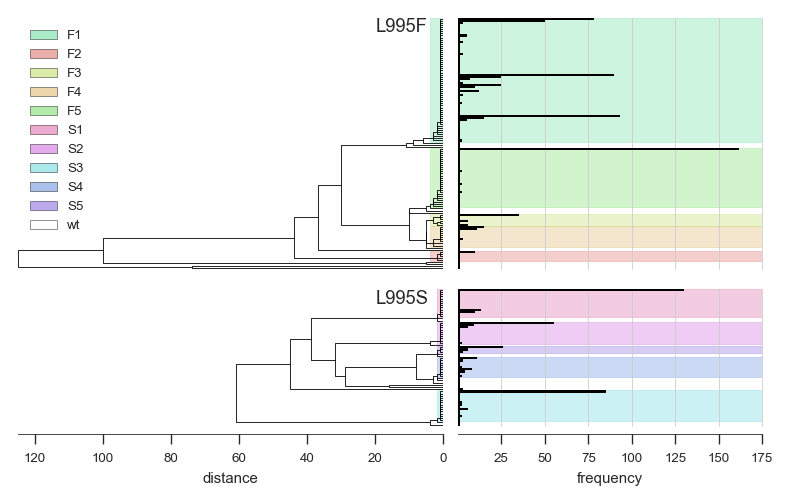

In [327]:
fig = plt.figure(figsize=(8, 4.5), dpi=120)



# define subplot layout
gs_nrows = 2
gs_ncols = 2
width_ratios = (1.4, 1)
height_ratios = (5.5, 3)
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.1 , wspace=0.04, width_ratios=width_ratios, height_ratios=height_ratios)

ax_dend = fig.add_subplot(gs[0, 0])
ax_freq = fig.add_subplot(gs[0, 1])
fig_haplotypes_clustered_piffle(h_vgsc_995F, orientation='left', dpi=150, 
                                ax_dend=ax_dend, ax_freq=ax_freq, 
                                highlight_clusters=5, label_clusters=None,
                                cut_height=4, highlight_colors=kdr_palette[0:5])

ax_dend = fig.add_subplot(gs[1, 0])
ax_freq = fig.add_subplot(gs[1, 1])
fig_haplotypes_clustered_piffle(h_vgsc_995S, orientation='left', dpi=150, 
                                ax_dend=ax_dend, ax_freq=ax_freq,
                                highlight_clusters=5, label_clusters=None, highlight_colors=kdr_palette[5:])

fig.savefig('Figure2_dendfreq_draft.jpg')

### ^^^ TO DO are the haplogroup names correct - do they contain approximately the same haplotypes as the ag1kg paper?

# Figure 3 - networks
- MJN
- Kick out network for all F/S in svg, cut appropriately
- Arrange into 2 panel figure with legend in inkscape

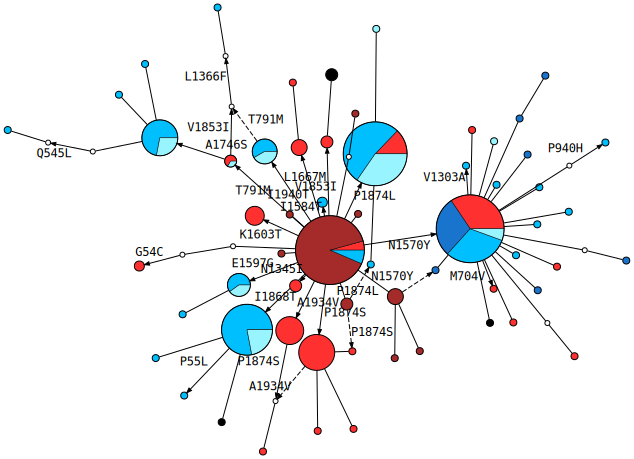

In [353]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph16 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                  network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                  show_node_labels=10000, fontsize='12', 
                                  variant_labels=variant_labels_vgsc, max_dist=4)
graph16

graph16.format = 'svg'
fn = '995F_cluster_16_mjn'
graph16.render(fn)

graph16

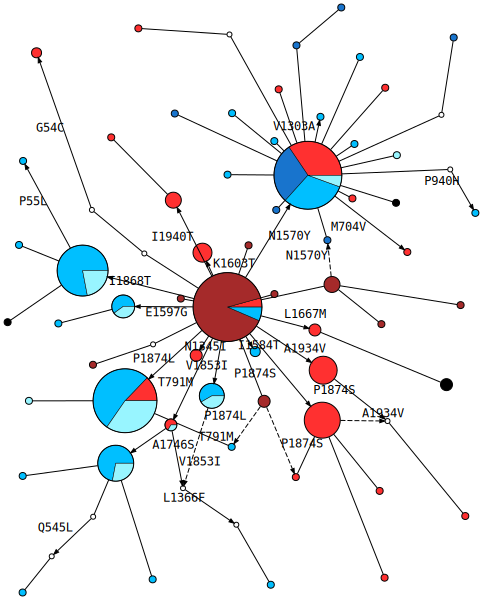

In [370]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph16 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                  network_method='mjn',edge_weight=8, overlap=False, splines=False,
                                  show_node_labels=10000, fontsize='12', 
                                  variant_labels=variant_labels_vgsc, max_dist=4)
graph16

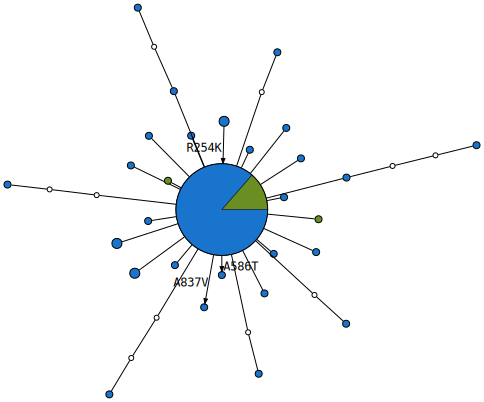

In [361]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph12 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                  network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                  show_node_labels=10000, fontsize='12', 
                                  variant_labels=variant_labels_vgsc, max_dist=4)


graph12.format = 'svg'
fn = '995F_cluster_12_mjn'
graph12.render(fn)

graph12

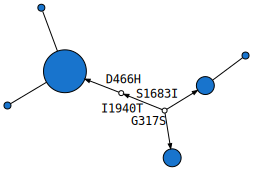

In [362]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
cluster_idx = 8
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph8 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                  network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                  show_node_labels=10000, fontsize='12', 
                                  variant_labels=variant_labels_vgsc, max_dist=4)

graph8.format = 'svg'
fn = '995F_cluster_8_mjn'
graph8.render(fn)

graph8

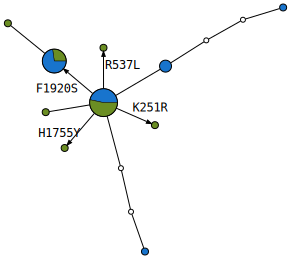

In [363]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
cluster_idx = 7
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph7 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                  network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                  show_node_labels=10000, fontsize='12', 
                                  variant_labels=variant_labels_vgsc, max_dist=4)

graph7.format = 'svg'
fn = '995F_cluster_7_mjn'
graph7.render(fn)

graph7

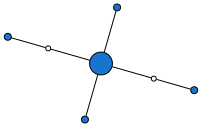

In [364]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
cluster_idx = 4
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph4 = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                  network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                  show_node_labels=10000, fontsize='12', 
                                  variant_labels=variant_labels_vgsc, max_dist=4)

graph4.format = 'svg'
fn = '995F_cluster_4_mjn'
graph4.render(fn)

graph4

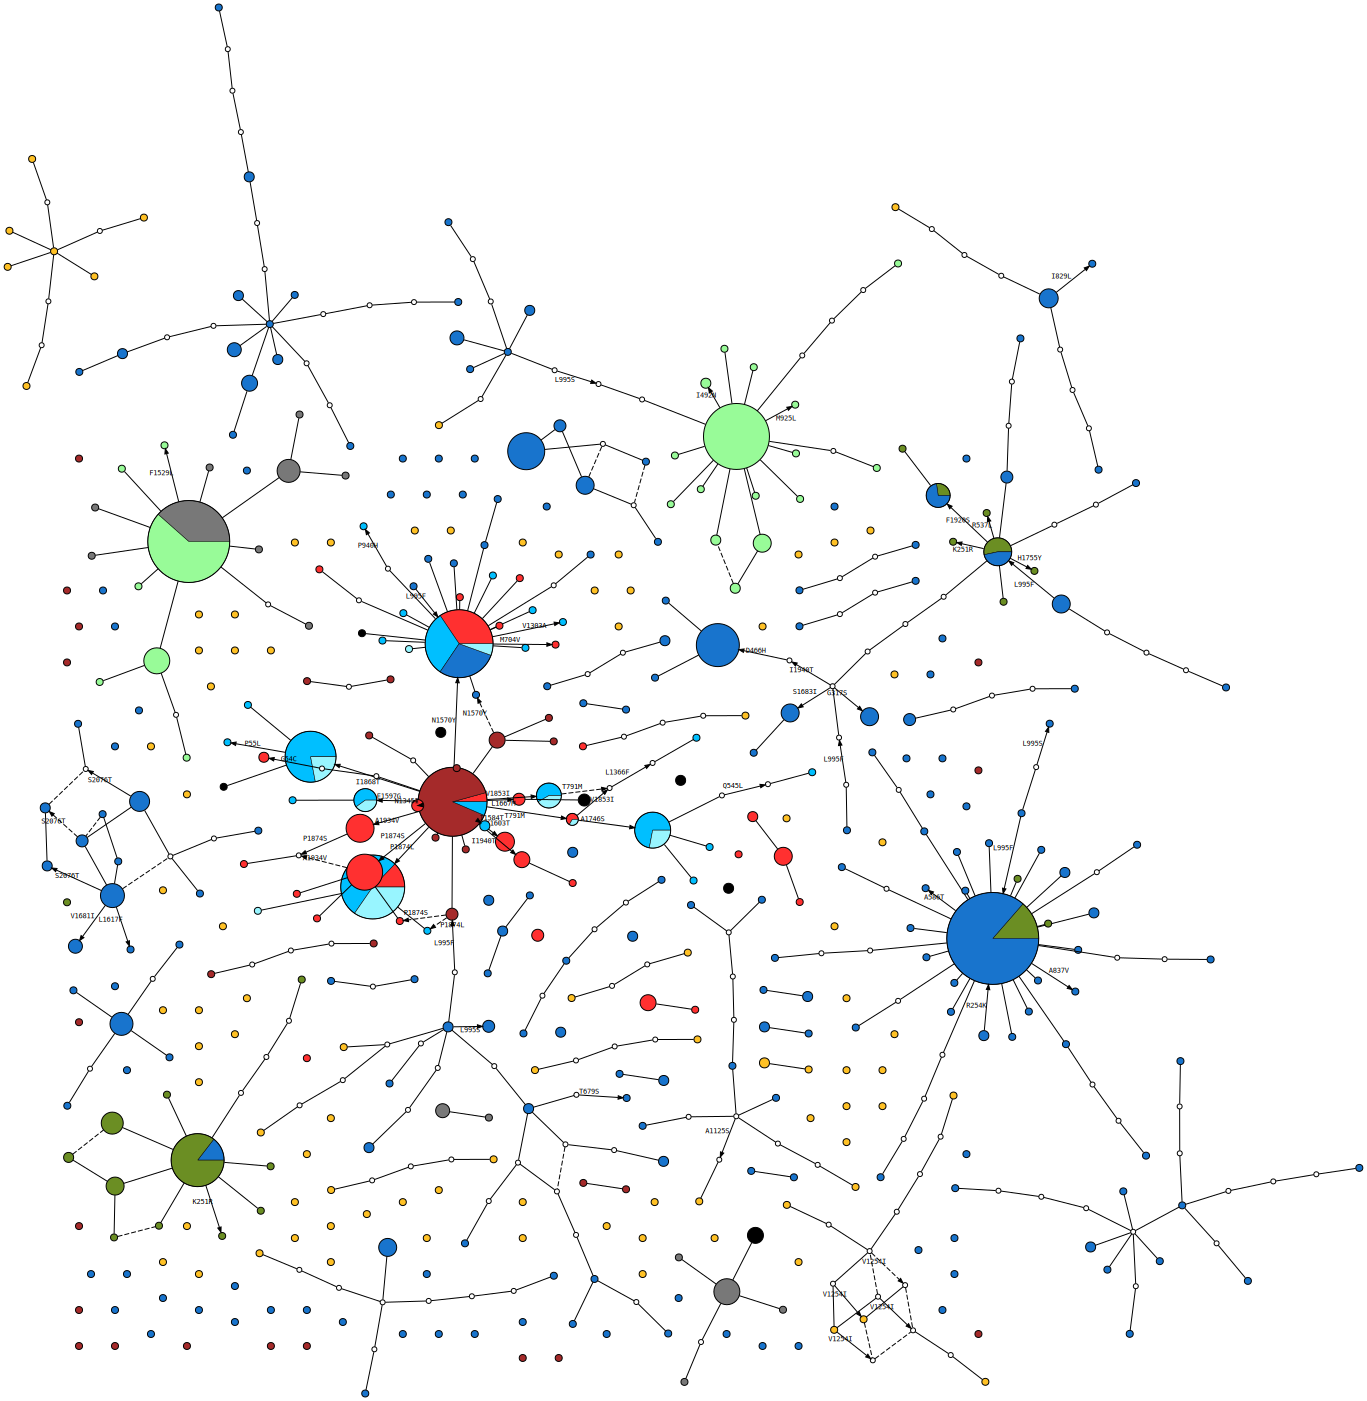

In [330]:
# just for fun, graph the whole lot...
graph = graph_haplotype_network(h_vgsc, hap_colors=hap_colors, network_method='mjn', 
                                variant_labels=variant_labels_vgsc, fontsize=7, show_node_labels=10000, max_dist=4)
graph